In [2]:
import pandas as pd, numpy as np, re

In [4]:
tmdb_path = "TMDB_movie_dataset_v11.csv"

# peek only the header to see the available columns (fast)
available_cols = pd.read_csv(tmdb_path, nrows=0).columns.tolist()
print(f"{len(available_cols)} columns found:")
print(available_cols)


24 columns found:
['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']


In [6]:
# columns to keep for analysis
KEEP_COLS = [
    "id","title","release_date","runtime","genres",
    "budget","revenue","vote_average","vote_count",
    "popularity","belongs_to_collection","adult","original_language"
]

# intersect with what's actually present in the file
usecols = [c for c in KEEP_COLS if c in available_cols]
missing  = [c for c in KEEP_COLS if c not in available_cols]
print("Will load:", usecols)
print("Not present (that’s fine):", missing)

# load only the needed columns
tmdb = pd.read_csv(tmdb_path, usecols=usecols, low_memory=False)

print("Shape after column select:", tmdb.shape)
tmdb.head(5)

Will load: ['id', 'title', 'release_date', 'runtime', 'genres', 'budget', 'revenue', 'vote_average', 'vote_count', 'popularity', 'adult', 'original_language']
Not present (that’s fine): ['belongs_to_collection']
Shape after column select: (1293249, 12)


,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,budget,original_language,popularity,genres
0,27205,Inception,8.364,34495,2010-07-15,825532764,148,False,160000000,en,83.952,"Action, Science Fiction, Adventure"
1,157336,Interstellar,8.417,32571,2014-11-05,701729206,169,False,165000000,en,140.241,"Adventure, Drama, Science Fiction"
2,155,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,False,185000000,en,130.643,"Drama, Action, Crime, Thriller"
3,19995,Avatar,7.573,29815,2009-12-15,2923706026,162,False,237000000,en,79.932,"Action, Adventure, Fantasy, Science Fiction"
4,24428,The Avengers,7.710,29166,2012-04-25,1518815515,143,False,220000000,en,98.082,"Science Fiction, Action, Adventure"


In [16]:
# CELL 4 — minimal cleaning + scope filter + MONTH NAME ONLY

def normalize_title(s):
    if pd.isna(s): return ""
    s = s.lower()
    s = re.sub(r'[\u2010-\u2015]', '-', s)      # normalize unicode dashes
    s = re.sub(r"[^a-z0-9\s\-:]", " ", s)       # keep letters/numbers/space/-/:
    s = re.sub(r"\s+", " ", s).strip()
    return s

before_rows = len(tmdb)

# 1) Dates → parts (month NAME only)
tmdb["release_date"] = pd.to_datetime(tmdb["release_date"], errors="coerce")
tmdb["year"]        = tmdb["release_date"].dt.year
tmdb["month_name"]  = tmdb["release_date"].dt.month_name()
tmdb["quarter"]     = tmdb["release_date"].dt.quarter

# 2) Numerics; treat 0 as missing for budget/revenue
for c in ["runtime","vote_average","vote_count","popularity","budget","revenue"]:
    if c in tmdb.columns:
        tmdb[c] = pd.to_numeric(tmdb[c], errors="coerce")
for c in ["budget","revenue"]:
    if c in tmdb.columns:
        tmdb[c] = tmdb[c].replace(0, np.nan)

# 3) Scope: 2018–2024 and non-adult (if column exists)
mask = tmdb["year"].between(2018, 2024, inclusive="both")
if "adult" in tmdb.columns:
    is_adult = tmdb["adult"].astype(str).str.lower().isin(["true","1","t","yes"])
    mask = mask & (~is_adult)
tmdb = tmdb[mask].copy()

# 4) Normalized title for future joins
tmdb["title_norm"] = tmdb["title"].apply(normalize_title)

# 5) Reorder columns so YEAR, MONTH NAME, QUARTER appear immediately after release_date
if "release_date" in tmdb.columns:
    pos = tmdb.columns.get_loc("release_date") + 1
    for col in ["year", "month_name", "quarter"]:
        if col in tmdb.columns:
            s = tmdb.pop(col)          # remove column (returns the Series)
            tmdb.insert(pos, col, s)   # insert right after release_date
            pos += 1

after_rows = len(tmdb)
print(f"Rows: {before_rows} → {after_rows}  ({after_rows/before_rows:.2%} kept)")
print("Pct missing (budget/revenue/runtime/rating/votes):",
      (tmdb[["budget","revenue","runtime","vote_average","vote_count"]].isna().mean()*100).round(1).to_dict())

tmdb.head(5)

Rows: 264401 → 264401  (100.00% kept)
Pct missing (budget/revenue/runtime/rating/votes): {'budget': 91.1, 'revenue': 98.2, 'runtime': 0.0, 'vote_average': 0.0, 'vote_count': 0.0}


,id,title,vote_average,vote_count,release_date,year,month_name,quarter,revenue,runtime,adult,budget,original_language,popularity,genres,title_norm
6,299536,Avengers: Infinity War,8.255,27713,2018-04-25,2018,April,2,2.052415e+09,149,False,300000000.0,en,154.340,"Adventure, Action, Science Fiction",avengers: infinity war
15,299534,Avengers: Endgame,8.263,23857,2019-04-24,2019,April,2,2.800000e+09,181,False,356000000.0,en,91.756,"Adventure, Science Fiction, Action",avengers: endgame
18,475557,Joker,8.168,23425,2019-10-01,2019,October,4,1.074458e+09,122,False,55000000.0,en,54.522,"Crime, Thriller, Drama",joker
27,284054,Black Panther,7.390,21053,2018-02-13,2018,February,1,1.349926e+09,135,False,200000000.0,en,43.665,"Action, Adventure, Science Fiction",black panther
57,634649,Spider-Man: No Way Home,7.990,18299,2021-12-15,2021,December,4,1.921847e+09,148,False,200000000.0,en,186.065,"Action, Adventure, Science Fiction",spider-man: no way home


In [18]:
# CELL 5 — trim to final working columns

final_cols = [
    "id","title","title_norm",
    "release_date","year","month_name","quarter",
    "runtime","genres","budget","revenue",
    "vote_average","vote_count","popularity",
    "belongs_to_collection","original_language"
]
final_cols = [c for c in final_cols if c in tmdb.columns]  # keep only those that exist

tmdb = (tmdb[final_cols]
        .drop_duplicates(subset=["id","title","release_date"])
        .reset_index(drop=True))

print("Kept columns:", tmdb.columns.tolist())
print("Shape:", tmdb.shape)
tmdb.head(5)


Kept columns: ['id', 'title', 'title_norm', 'release_date', 'year', 'month_name', 'quarter', 'runtime', 'genres', 'budget', 'revenue', 'vote_average', 'vote_count', 'popularity', 'original_language']
Shape: (264340, 15)


,id,title,title_norm,release_date,year,month_name,quarter,runtime,genres,budget,revenue,vote_average,vote_count,popularity,original_language
0,299536,Avengers: Infinity War,avengers: infinity war,2018-04-25,2018,April,2,149,"Adventure, Action, Science Fiction",300000000.0,2.052415e+09,8.255,27713,154.340,en
1,299534,Avengers: Endgame,avengers: endgame,2019-04-24,2019,April,2,181,"Adventure, Science Fiction, Action",356000000.0,2.800000e+09,8.263,23857,91.756,en
2,475557,Joker,joker,2019-10-01,2019,October,4,122,"Crime, Thriller, Drama",55000000.0,1.074458e+09,8.168,23425,54.522,en
3,284054,Black Panther,black panther,2018-02-13,2018,February,1,135,"Action, Adventure, Science Fiction",200000000.0,1.349926e+09,7.390,21053,43.665,en
4,634649,Spider-Man: No Way Home,spider-man: no way home,2021-12-15,2021,December,4,148,"Action, Adventure, Science Fiction",200000000.0,1.921847e+09,7.990,18299,186.065,en


In [20]:
tmdb.to_csv("tmdb_clean_2018_2024.csv", index=False)
print("Saved tmdb_clean_2018_2024.csv in the current folder.")


Saved tmdb_clean_2018_2024.csv in the current folder.


In [22]:
stream_path = "MoviesOnStreamingPlatforms.csv"  # or "TMDP Movie Datasets/MoviesOnStreamingPlatforms.csv"

import pandas as pd

stream_raw = pd.read_csv(stream_path)
print(stream_raw.shape)
print(stream_raw.columns.tolist()[:50])  # show first ~50 column names
stream_raw.head(5)


(9515, 11)
['Unnamed: 0', 'ID', 'Title', 'Year', 'Age', 'Rotten Tomatoes', 'Netflix', 'Hulu', 'Prime Video', 'Disney+', 'Type']


,Unnamed: 0,ID,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,0,1,The Irishman,2019,18+,98/100,1,0,0,0,0
1,1,2,Dangal,2016,7+,97/100,1,0,0,0,0
2,2,3,David Attenborough: A Life on Our Planet,2020,7+,95/100,1,0,0,0,0
3,3,4,Lagaan: Once Upon a Time in India,2001,7+,94/100,1,0,0,0,0
4,4,5,Roma,2018,18+,94/100,1,0,0,0,0


In [24]:
# Start from what you loaded in S1
stream = stream_raw.copy()

# 1) Rename to clean, consistent names
stream = stream.rename(columns={
    "Title": "title",
    "Year": "year",
    "Age": "age",
    "Rotten Tomatoes": "rotten_tomatoes",
    "Netflix": "netflix",
    "Hulu": "hulu",
    "Prime Video": "prime_video",
    "Disney+": "disney_plus",
    "Type": "type"
})

# 2) Drop the stray index column if present
stream = stream.drop(columns=["Unnamed: 0"], errors="ignore")

print(stream.shape)
print(stream.columns.tolist())
stream.head(5)


(9515, 10)
['ID', 'title', 'year', 'age', 'rotten_tomatoes', 'netflix', 'hulu', 'prime_video', 'disney_plus', 'type']


,ID,title,year,age,rotten_tomatoes,netflix,hulu,prime_video,disney_plus,type
0,1,The Irishman,2019,18+,98/100,1,0,0,0,0
1,2,Dangal,2016,7+,97/100,1,0,0,0,0
2,3,David Attenborough: A Life on Our Planet,2020,7+,95/100,1,0,0,0,0
3,4,Lagaan: Once Upon a Time in India,2001,7+,94/100,1,0,0,0,0
4,5,Roma,2018,18+,94/100,1,0,0,0,0


In [26]:
import re
import numpy as np

# Work on the standardized DataFrame `stream` from S2
s = stream.copy()

# 1) Parse "Rotten Tomatoes" like "98/100" -> 98 (int)
def parse_rt(x):
    if pd.isna(x): 
        return np.nan
    m = re.match(r"\s*(\d{1,3})\s*/\s*100\s*$", str(x))
    return int(m.group(1)) if m else pd.to_numeric(x, errors="coerce")

s["rt_score"] = s["rotten_tomatoes"].apply(parse_rt)

# 2) Confirm Type meaning and filter to movies
# In this dataset: 0 = movie, 1 = TV show
print("Unique values in 'type':", s["type"].unique().tolist())
s = s[s["type"] == 0].copy()

# 3) Ensure platform flags are clean 0/1 ints
for col in ["netflix","hulu","prime_video","disney_plus"]:
    if col in s.columns:
        s[col] = s[col].fillna(0).astype(int)

print(s.shape)
s[["title","year","rt_score","netflix","hulu","prime_video","disney_plus"]].head(5)


Unique values in 'type': [0]
(9515, 11)


,title,year,rt_score,netflix,hulu,prime_video,disney_plus
0,The Irishman,2019,98.0,1,0,0,0
1,Dangal,2016,97.0,1,0,0,0
2,David Attenborough: A Life on Our Planet,2020,95.0,1,0,0,0
3,Lagaan: Once Upon a Time in India,2001,94.0,1,0,0,0
4,Roma,2018,94.0,1,0,0,0


In [30]:
def normalize_title(s):
    if pd.isna(s): return ""
    s = s.lower()
    s = re.sub(r'[\u2010-\u2015]', '-', s)
    s = re.sub(r"[^a-z0-9\s\-:]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# 1) normalized title for future joining
s["title_norm"] = s["title"].apply(normalize_title)

# 2) ensure year is numeric, then focus on snapshot coverage (2018–2021)
s["year"] = pd.to_numeric(s["year"], errors="coerce").astype("Int64")
stream_clean = s[s["year"].between(2018, 2021, inclusive="both")].copy()

# 3) keep tidy columns
keep = ["title","title_norm","year","age","rt_score","netflix","hulu","prime_video","disney_plus"]
keep = [c for c in keep if c in stream_clean.columns]
stream_clean = stream_clean[keep].drop_duplicates().reset_index(drop=True)

# quick info
print("Shape:", stream_clean.shape)
for col in ["netflix","hulu","prime_video","disney_plus"]:
    if col in stream_clean.columns:
        print(f"{col}: {int(stream_clean[col].sum())} titles")

stream_clean.head(5)


Shape: (3148, 9)
netflix: 1792 titles
hulu: 417 titles
prime_video: 808 titles
disney_plus: 183 titles


,title,title_norm,year,age,rt_score,netflix,hulu,prime_video,disney_plus
0,The Irishman,the irishman,2019,18+,98.0,1,0,0,0
1,David Attenborough: A Life on Our Planet,david attenborough: a life on our planet,2020,7+,95.0,1,0,0,0
2,Roma,roma,2018,18+,94.0,1,0,0,0
3,To All the Boys I've Loved Before,to all the boys i ve loved before,2018,13+,94.0,1,0,0,0
4,The Social Dilemma,the social dilemma,2020,13+,93.0,1,0,0,0


In [32]:
# save cleaned streaming data
stream_out = "streaming_clean_2018_2021.csv"  # save next to your notebook; rename if you like
stream_clean.to_csv(stream_out, index=False)
print(f"Saved: {stream_out}  |  rows={len(stream_clean)}  cols={stream_clean.shape[1]}")
stream_clean.head(3)


Saved: streaming_clean_2018_2021.csv  |  rows=3148  cols=9


,title,title_norm,year,age,rt_score,netflix,hulu,prime_video,disney_plus
0,The Irishman,the irishman,2019,18+,98.0,1,0,0,0
1,David Attenborough: A Life on Our Planet,david attenborough: a life on our planet,2020,7+,95.0,1,0,0,0
2,Roma,roma,2018,18+,94.0,1,0,0,0


In [34]:
import pandas as pd

tmdb_clean_path = "tmdb_clean_2018_2024.csv"         
stream_clean_path = "streaming_clean_2018_2021.csv" 

tm = pd.read_csv(tmdb_clean_path)
st = pd.read_csv(stream_clean_path)

print("TMDb:", tm.shape, " | cols:", list(tm.columns)[:12], "...")
print("Streaming:", st.shape, " | cols:", list(st.columns)[:12], "...")

# quick checks for required columns
req_tm = {"title_norm","year","release_date","budget","revenue"}
req_st = {"title_norm","year","netflix","hulu","prime_video","disney_plus"}
print("TMDb has all required:", req_tm.issubset(tm.columns))
print("Streaming has all required:", req_st.issubset(st.columns))
tm.head(3)


TMDb: (264340, 15)  | cols: ['id', 'title', 'title_norm', 'release_date', 'year', 'month_name', 'quarter', 'runtime', 'genres', 'budget', 'revenue', 'vote_average'] ...
Streaming: (3148, 9)  | cols: ['title', 'title_norm', 'year', 'age', 'rt_score', 'netflix', 'hulu', 'prime_video', 'disney_plus'] ...
TMDb has all required: True
Streaming has all required: True


,id,title,title_norm,release_date,year,month_name,quarter,runtime,genres,budget,revenue,vote_average,vote_count,popularity,original_language
0,299536,Avengers: Infinity War,avengers: infinity war,2018-04-25,2018,April,2,149,"Adventure, Action, Science Fiction",300000000.0,2.052415e+09,8.255,27713,154.340,en
1,299534,Avengers: Endgame,avengers: endgame,2019-04-24,2019,April,2,181,"Adventure, Science Fiction, Action",356000000.0,2.800000e+09,8.263,23857,91.756,en
2,475557,Joker,joker,2019-10-01,2019,October,4,122,"Crime, Thriller, Drama",55000000.0,1.074458e+09,8.168,23425,54.522,en


In [36]:
import pandas as pd
import numpy as np

# 1) Expand streaming years by ±1 so near-matches can join
exp = []
for dy in (-1, 0, 1):
    tmp = st.copy()
    tmp["join_year"] = tmp["year"] + dy
    exp.append(tmp[["title_norm","join_year","netflix","hulu","prime_video","disney_plus","rt_score"]])

right = (pd.concat(exp, ignore_index=True)
           .groupby(["title_norm","join_year"], as_index=False)
           .agg({
               "netflix":"max", "hulu":"max", "prime_video":"max", "disney_plus":"max",
               "rt_score":"max"   # pick a single score per key if duplicates occur
           }))

# 2) Prepare TMDb side
tm2 = tm.copy()
tm2["join_year"] = tm2["year"]

# 3) Merge
merged = tm2.merge(right, how="left", on=["title_norm","join_year"])

print("Merged shape:", merged.shape)
merged[["title","year","release_date","netflix","hulu","prime_video","disney_plus","rt_score"]].head(8)

Merged shape: (264340, 21)


,title,year,release_date,netflix,hulu,prime_video,disney_plus,rt_score
0,Avengers: Infinity War,2018,2018-04-25,0.0,0.0,0.0,1.0,90.0
1,Avengers: Endgame,2019,2019-04-24,0.0,0.0,0.0,1.0,90.0
2,Joker,2019,2019-10-01,NaN,NaN,NaN,NaN,NaN
3,Black Panther,2018,2018-02-13,0.0,0.0,0.0,1.0,84.0
4,Spider-Man: No Way Home,2021,2021-12-15,NaN,NaN,NaN,NaN,NaN
5,Parasite,2019,2019-05-30,0.0,1.0,0.0,0.0,88.0
6,Deadpool 2,2018,2018-05-10,NaN,NaN,NaN,NaN,NaN
7,Bohemian Rhapsody,2018,2018-10-24,0.0,1.0,0.0,0.0,85.0


In [38]:
# Label: revenue>0 → theatrical; else any platform flag → streaming; else unknown
for col in ["netflix","hulu","prime_video","disney_plus"]:
    if col in merged.columns:
        merged[col] = merged[col].fillna(0).astype(int)

merged["on_any_platform"] = merged[["netflix","hulu","prime_video","disney_plus"]].sum(axis=1) > 0
merged["is_theatrical"]   = merged["revenue"].notna() & (merged["revenue"] > 0)
merged["channel"] = np.where(merged["is_theatrical"], "theatrical",
                      np.where(merged["on_any_platform"], "streaming", "unknown"))

print(merged["channel"].value_counts(dropna=False))
merged[["title","year","release_date","channel","netflix","hulu","prime_video","disney_plus","rt_score"]].head(8)


channel
unknown       256432
theatrical      4672
streaming       3236
Name: count, dtype: int64


,title,year,release_date,channel,netflix,hulu,prime_video,disney_plus,rt_score
0,Avengers: Infinity War,2018,2018-04-25,theatrical,0,0,0,1,90.0
1,Avengers: Endgame,2019,2019-04-24,theatrical,0,0,0,1,90.0
2,Joker,2019,2019-10-01,theatrical,0,0,0,0,NaN
3,Black Panther,2018,2018-02-13,theatrical,0,0,0,1,84.0
4,Spider-Man: No Way Home,2021,2021-12-15,theatrical,0,0,0,0,NaN
5,Parasite,2019,2019-05-30,theatrical,0,1,0,0,88.0
6,Deadpool 2,2018,2018-05-10,theatrical,0,0,0,0,NaN
7,Bohemian Rhapsody,2018,2018-10-24,theatrical,0,1,0,0,85.0


In [40]:
# filter to labeled cohorts only
labeled = merged.loc[merged["channel"].isin(["theatrical", "streaming"])].copy()

print("Counts after filtering:")
print(labeled["channel"].value_counts())

# quick peek
labeled[["title","year","release_date","channel",
         "netflix","hulu","prime_video","disney_plus","rt_score"]].head(8)


Counts after filtering:
channel
theatrical    4672
streaming     3236
Name: count, dtype: int64


,title,year,release_date,channel,netflix,hulu,prime_video,disney_plus,rt_score
0,Avengers: Infinity War,2018,2018-04-25,theatrical,0,0,0,1,90.0
1,Avengers: Endgame,2019,2019-04-24,theatrical,0,0,0,1,90.0
2,Joker,2019,2019-10-01,theatrical,0,0,0,0,NaN
3,Black Panther,2018,2018-02-13,theatrical,0,0,0,1,84.0
4,Spider-Man: No Way Home,2021,2021-12-15,theatrical,0,0,0,0,NaN
5,Parasite,2019,2019-05-30,theatrical,0,1,0,0,88.0
6,Deadpool 2,2018,2018-05-10,theatrical,0,0,0,0,NaN
7,Bohemian Rhapsody,2018,2018-10-24,theatrical,0,1,0,0,85.0


In [42]:
# features for modeling/EDA

import numpy as np
import pandas as pd
import re

df = labeled.copy()

# 1) Log transforms for skewed fields
if "budget" in df.columns:      df["log_budget"] = np.log1p(df["budget"].astype(float))
if "revenue" in df.columns:     df["log_revenue"] = np.log1p(df["revenue"].astype(float))
if "vote_count" in df.columns:  df["log_votes"] = np.log1p(df["vote_count"].astype(float))
if "popularity" in df.columns:  df["log_popularity"] = np.log1p(df["popularity"].astype(float))

# 2) ROI (only when both budget & revenue exist)
df["roi"] = np.where(df[["budget","revenue"]].notna().all(axis=1),
                     df["revenue"] / df["budget"], np.nan)
df["log_roi"] = np.log1p(df["roi"])

# 3) Release season from month_name
def month_to_season(name):
    if pd.isna(name): return np.nan
    name = str(name)
    if name in ("December",):                     return "Holiday"
    if name in ("June","July","August"):          return "Summer"
    if name in ("March","April","May"):           return "Spring"
    if name in ("September","October","November"):return "Fall"
    if name in ("January","February"):            return "Winter"
    return np.nan

df["release_season"] = df["month_name"].apply(month_to_season)

# 4) Main genre (first listed or first JSON 'name')
def extract_main_genre(g):
    if pd.isna(g): return np.nan
    s = str(g)
    names = re.findall(r'"name":\s*"([^"]+)"', s) or re.findall(r"'name':\s*'([^']+)'", s)
    if names: 
        return names[0]
    return s.split(",")[0].strip()  # comma-separated fallback

df["main_genre"] = df["genres"].apply(extract_main_genre)

# put back
labeled = df

print("Added features:",
      [c for c in ["log_budget","log_revenue","log_votes","log_popularity","roi","log_roi","release_season","main_genre"]
       if c in labeled.columns])
labeled.head(5)[["title","channel","budget","revenue","log_budget","log_revenue","roi","release_season","main_genre"]]


Added features: ['log_budget', 'log_revenue', 'log_votes', 'log_popularity', 'roi', 'log_roi', 'release_season', 'main_genre']


,title,channel,budget,revenue,log_budget,log_revenue,roi,release_season,main_genre
0,Avengers: Infinity War,theatrical,300000000.0,2.052415e+09,19.519293,21.442283,6.841383,Spring,Adventure
1,Avengers: Endgame,theatrical,356000000.0,2.800000e+09,19.690441,21.752885,7.865169,Spring,Adventure
2,Joker,theatrical,55000000.0,1.074458e+09,17.822844,20.795082,19.535605,Fall,Crime
3,Black Panther,theatrical,200000000.0,1.349926e+09,19.113828,21.023316,6.749630,Winter,Action
4,Spider-Man: No Way Home,theatrical,200000000.0,1.921847e+09,19.113828,21.376553,9.609236,Holiday,Action


In [44]:
# Save the merged dataset to CSV
df = labeled.copy()

# Keep a tidy column order (only the ones that exist in your df)
cols = [
    "id","title","title_norm",
    "release_date","year","month_name","quarter",
    "runtime","genres",
    "budget","revenue","log_budget","log_revenue","roi","log_roi",
    "vote_average","vote_count","log_votes",
    "popularity","log_popularity",
    "main_genre","release_season",
    "netflix","hulu","prime_video","disney_plus","rt_score",
    "channel"
]
df = df[[c for c in cols if c in df.columns]].drop_duplicates(subset=["title","year","channel"]).reset_index(drop=True)

df.to_csv("movies_merged.csv", index=False)
print(f"Saved movies_merged.csv | rows={len(df)} cols={df.shape[1]}")
df.head(5)


Saved movies_merged.csv | rows=7569 cols=28


,id,title,title_norm,release_date,year,month_name,quarter,runtime,genres,budget,...,popularity,log_popularity,main_genre,release_season,netflix,hulu,prime_video,disney_plus,rt_score,channel
0,299536,Avengers: Infinity War,avengers: infinity war,2018-04-25,2018,April,2,149,"Adventure, Action, Science Fiction",300000000.0,...,154.340,5.045616,Adventure,Spring,0,0,0,1,90.0,theatrical
1,299534,Avengers: Endgame,avengers: endgame,2019-04-24,2019,April,2,181,"Adventure, Science Fiction, Action",356000000.0,...,91.756,4.529972,Adventure,Spring,0,0,0,1,90.0,theatrical
2,475557,Joker,joker,2019-10-01,2019,October,4,122,"Crime, Thriller, Drama",55000000.0,...,54.522,4.016779,Crime,Fall,0,0,0,0,NaN,theatrical
3,284054,Black Panther,black panther,2018-02-13,2018,February,1,135,"Action, Adventure, Science Fiction",200000000.0,...,43.665,3.799190,Action,Winter,0,0,0,1,84.0,theatrical
4,634649,Spider-Man: No Way Home,spider-man: no way home,2021-12-15,2021,December,4,148,"Action, Adventure, Science Fiction",200000000.0,...,186.065,5.231456,Action,Holiday,0,0,0,0,NaN,theatrical


In [70]:
import pandas as pd
import numpy as np

# load merged dataset
df = pd.read_csv("movies_merged.csv")

# split into cohorts
theatrical = df[df["channel"] == "theatrical"].copy()
streaming  = df[df["channel"] == "streaming"].copy()

print("All rows:", len(df))
print("Theatrical:", len(theatrical))
print("Streaming:", len(streaming))

# quick sanity: show the key columns we’ll use
print(sorted(set([
    *[c for c in ["log_revenue","log_budget","roi","log_roi","runtime","vote_average","vote_count","log_votes","popularity","log_popularity"] if c in df.columns],
    *[c for c in ["release_season","main_genre","rt_score","netflix","hulu","prime_video","disney_plus"] if c in df.columns]
])))
df.head(3)


All rows: 7569
Theatrical: 4643
Streaming: 2926
['disney_plus', 'hulu', 'log_budget', 'log_popularity', 'log_revenue', 'log_roi', 'log_votes', 'main_genre', 'netflix', 'popularity', 'prime_video', 'release_season', 'roi', 'rt_score', 'runtime', 'vote_average', 'vote_count']


,id,title,title_norm,release_date,year,month_name,quarter,runtime,genres,budget,...,popularity,log_popularity,main_genre,release_season,netflix,hulu,prime_video,disney_plus,rt_score,channel
0,299536,Avengers: Infinity War,avengers: infinity war,2018-04-25,2018,April,2,149,"Adventure, Action, Science Fiction",300000000.0,...,154.340,5.045616,Adventure,Spring,0,0,0,1,90.0,theatrical
1,299534,Avengers: Endgame,avengers: endgame,2019-04-24,2019,April,2,181,"Adventure, Science Fiction, Action",356000000.0,...,91.756,4.529972,Adventure,Spring,0,0,0,1,90.0,theatrical
2,475557,Joker,joker,2019-10-01,2019,October,4,122,"Crime, Thriller, Drama",55000000.0,...,54.522,4.016779,Crime,Fall,0,0,0,0,NaN,theatrical


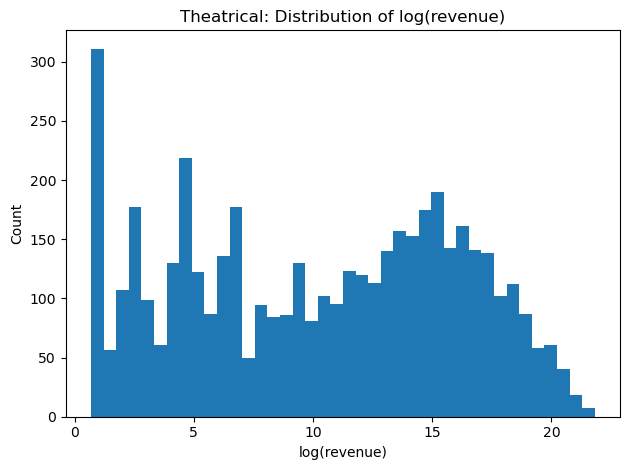

In [72]:
import os
import matplotlib.pyplot as plt

# make sure we have data
assert "log_revenue" in theatrical.columns, "log_revenue not found in theatrical cohort."

# optional: save directory for figures
os.makedirs("figs", exist_ok=True)

plt.figure()
theatrical["log_revenue"].dropna().plot(kind="hist", bins=40)
plt.title("Theatrical: Distribution of log(revenue)")
plt.xlabel("log(revenue)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figs/hist_log_revenue.png", dpi=300)
plt.show()


Missing % (budget): 33.4
Median budget (USD, non-missing): 1200.0


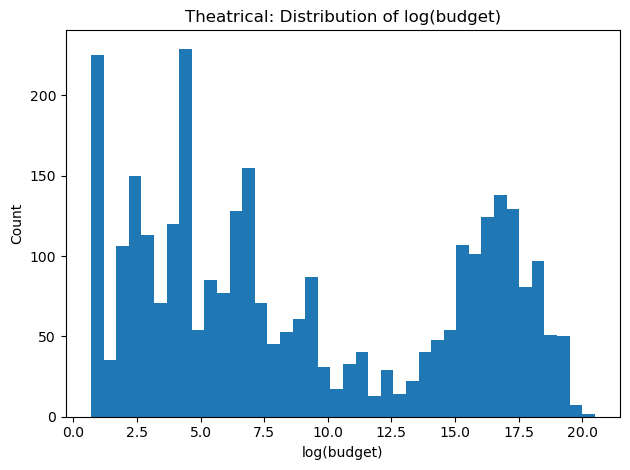

In [50]:
#  heatrical: histogram of log(budget)

import os, numpy as np, matplotlib.pyplot as plt
os.makedirs("figs", exist_ok=True)

# safety: create log_budget if it's not there
if "log_budget" not in theatrical.columns and "budget" in theatrical.columns:
    theatrical["log_budget"] = np.log1p(theatrical["budget"].astype(float))

# quick stats for your write-up
print("Missing % (budget):", round(theatrical["budget"].isna().mean()*100, 1))
print("Median budget (USD, non-missing):", theatrical["budget"].dropna().median())

plt.figure()
theatrical["log_budget"].dropna().plot(kind="hist", bins=40)
plt.title("Theatrical: Distribution of log(budget)")
plt.xlabel("log(budget)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figs/hist_log_budget.png", dpi=300)
plt.show()


Pearson r = 0.913 | Spearman ρ = 0.890  (n=3093)


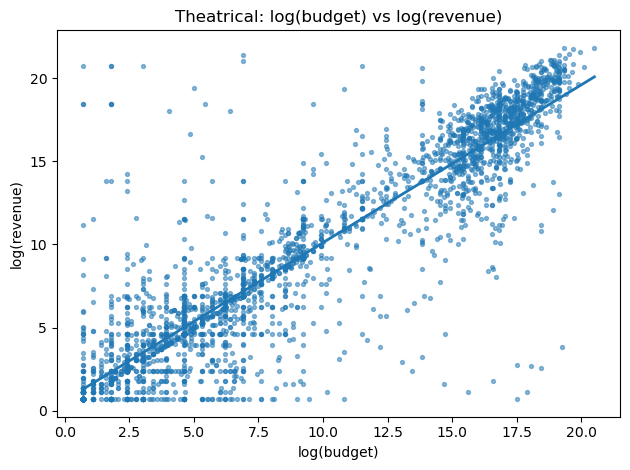

In [52]:
# Theatrical: log(budget) vs log(revenue) + correlations

import numpy as np, matplotlib.pyplot as plt

# make sure columns exist
if "log_budget" not in theatrical.columns and "budget" in theatrical.columns:
    theatrical["log_budget"] = np.log1p(theatrical["budget"].astype(float))
if "log_revenue" not in theatrical.columns and "revenue" in theatrical.columns:
    theatrical["log_revenue"] = np.log1p(theatrical["revenue"].astype(float))

# drop missing
m = theatrical[["log_budget","log_revenue"]].dropna()

# correlations (report in console for your write-up)
pearson = m["log_budget"].corr(m["log_revenue"], method="pearson")
spearman = m["log_budget"].corr(m["log_revenue"], method="spearman")
print(f"Pearson r = {pearson:.3f} | Spearman ρ = {spearman:.3f}  (n={len(m)})")

# simple trend line (least-squares on the logs)
coef = np.polyfit(m["log_budget"], m["log_revenue"], 1)
xline = np.linspace(m["log_budget"].min(), m["log_budget"].max(), 100)
yline = coef[0]*xline + coef[1]

plt.figure()
plt.scatter(m["log_budget"], m["log_revenue"], s=8, alpha=0.5)
plt.plot(xline, yline, linewidth=2)  # trend line
plt.title("Theatrical: log(budget) vs log(revenue)")
plt.xlabel("log(budget)")
plt.ylabel("log(revenue)")
plt.tight_layout()
plt.savefig("figs/scatter_logbudget_logrevenue.png", dpi=300)
plt.show()


Median log(revenue) by season:
release_season
Fall       10.943407
Holiday     7.601402
Spring     10.206891
Summer     11.025247
Winter     12.278398
Name: log_revenue, dtype: float64


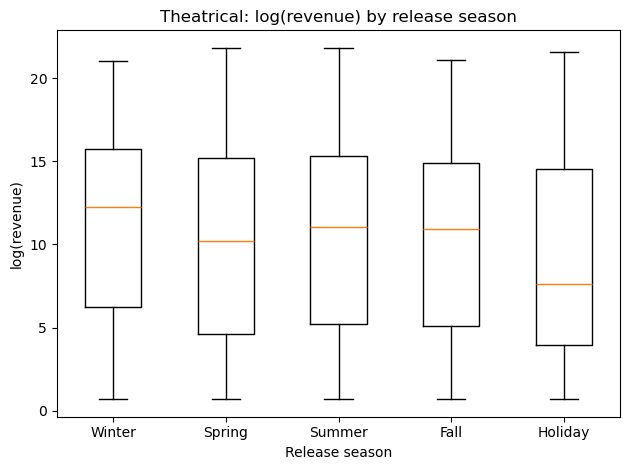

In [74]:
# Theatrical: log(revenue) by release_season (boxplot)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.makedirs("figs", exist_ok=True)

# ensure columns exist
if "log_revenue" not in theatrical.columns and "revenue" in theatrical.columns:
    theatrical["log_revenue"] = np.log1p(theatrical["revenue"].astype(float))

# drop rows without season or revenue
d = theatrical[["release_season","log_revenue"]].dropna().copy()

# order seasons logically
order = [s for s in ["Winter","Spring","Summer","Fall","Holiday"] if s in d["release_season"].unique()]

# quick medians for your writeup
med = d.groupby("release_season")["log_revenue"].median().sort_index()
print("Median log(revenue) by season:")
print(med)

plt.figure()
data = [d.loc[d["release_season"]==s, "log_revenue"].values for s in order]
plt.boxplot(data, labels=order, showfliers=False)
plt.title("Theatrical: log(revenue) by release season")
plt.ylabel("log(revenue)")
plt.xlabel("Release season")
plt.tight_layout()
plt.savefig("figs/box_logrevenue_by_season.png", dpi=300)
plt.show()


Missing % (rt_score): 0.1


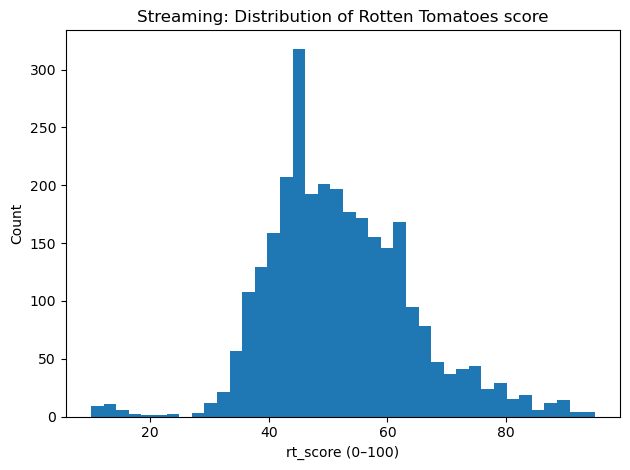

In [56]:
# S1 — Streaming: histogram of rt_score

import os, numpy as np, matplotlib.pyplot as plt
os.makedirs("figs", exist_ok=True)

# make sure the column exists and is numeric
assert "rt_score" in streaming.columns, "rt_score not found in streaming cohort."
rt = pd.to_numeric(streaming["rt_score"], errors="coerce")

print("Missing % (rt_score):", round(rt.isna().mean()*100, 1))

plt.figure()
rt.dropna().plot(kind="hist", bins=40)
plt.title("Streaming: Distribution of Rotten Tomatoes score")
plt.xlabel("rt_score (0–100)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figs/stream_hist_rt_score.png", dpi=300)
plt.show()


Counts by platform:
 {'Netflix': 1702, 'Prime Video': 777, 'Hulu': 351, 'Disney+': 168}
Median rt_score by platform:
 {'Disney+': 49.0, 'Hulu': 54.0, 'Netflix': 52.0, 'Prime Video': 47.0}


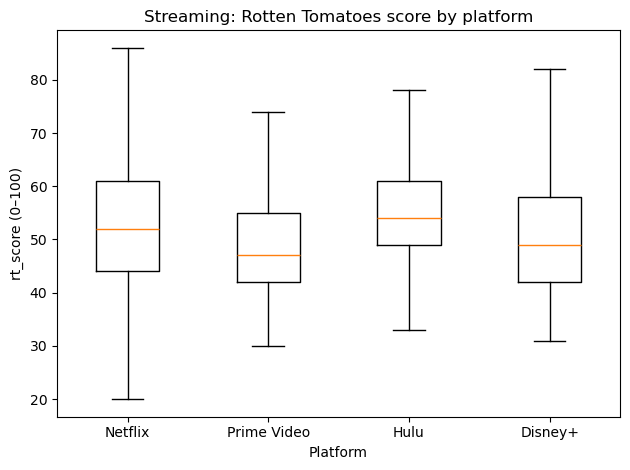

In [58]:
# S2 — Streaming: rt_score by platform (boxplot)

import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("figs", exist_ok=True)

platform_map = {
    "netflix": "Netflix",
    "prime_video": "Prime Video",
    "hulu": "Hulu",
    "disney_plus": "Disney+"
}

# build a long-form table: one row per (title, platform) where flag==1
parts = []
for col, label in platform_map.items():
    if col in streaming.columns:
        tmp = streaming.loc[streaming[col] == 1, ["rt_score"]].copy()
        tmp["platform"] = label
        parts.append(tmp)

long_df = pd.concat(parts, ignore_index=True)
long_df["rt_score"] = pd.to_numeric(long_df["rt_score"], errors="coerce")

# quick counts/medians for your write-up
print("Counts by platform:\n", long_df["platform"].value_counts().to_dict())
print("Median rt_score by platform:\n", long_df.groupby("platform")["rt_score"].median().round(1).to_dict())

# boxplot
order = [label for _, label in platform_map.items() if label in long_df["platform"].unique()]
plt.figure()
data = [long_df.loc[long_df["platform"]==p, "rt_score"].dropna().values for p in order]
plt.boxplot(data, labels=order, showfliers=False)
plt.title("Streaming: Rotten Tomatoes score by platform")
plt.ylabel("rt_score (0–100)")
plt.xlabel("Platform")
plt.tight_layout()
plt.savefig("figs/stream_box_rt_by_platform.png", dpi=300)
plt.show()


In [76]:
# tiny tables: channel counts, platform counts, missingness

import pandas as pd, os
os.makedirs("tables", exist_ok=True)

# 1) Channel counts
channel_counts = df["channel"].value_counts(dropna=False).rename_axis("channel").reset_index(name="n")
print("Channel counts:\n", channel_counts, "\n")
channel_counts.to_csv("tables/channel_counts.csv", index=False)

# 2) Platform counts (streaming cohort only)
platform_cols = [c for c in ["netflix","prime_video","hulu","disney_plus"] if c in streaming.columns]
platform_counts = (streaming[platform_cols].fillna(0).astype(int).sum()
                   .rename_axis("platform").reset_index(name="titles"))
print("Platform counts:\n", platform_counts, "\n")
platform_counts.to_csv("tables/platform_counts.csv", index=False)

# 3) Missingness (%), by cohort, for key fields
miss_cols = [c for c in ["budget","revenue","runtime","vote_average","vote_count","rt_score"] if c in df.columns]

miss_theatrical = theatrical[miss_cols].isna().mean().mul(100).round(1).to_frame(name="theatrical_%missing")
miss_streaming  = streaming[miss_cols].isna().mean().mul(100).round(1).to_frame(name="streaming_%missing")
missing_table   = miss_theatrical.join(miss_streaming, how="outer")
print("Missingness (%):\n", missing_table, "\n")
missing_table.to_csv("tables/missingness.csv")

# quick peek of where files are saved
print("Saved tables → tables/channel_counts.csv, platform_counts.csv, missingness.csv")


Channel counts:
       channel     n
0  theatrical  4643
1   streaming  2926 

Platform counts:
       platform  titles
0      netflix    1702
1  prime_video     777
2         hulu     351
3  disney_plus     168 

Missingness (%):
               theatrical_%missing  streaming_%missing
budget                       33.4                93.2
revenue                       0.0               100.0
rt_score                     91.5                 0.1
runtime                       0.0                 0.0
vote_average                  0.0                 0.0
vote_count                    0.0                 0.0 

Saved tables → tables/channel_counts.csv, platform_counts.csv, missingness.csv


In [64]:
# Elastic Net baseline for theatrical log(revenue)
import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score

# Use the same theatrical df we prepared earlier
th = df[df["channel"]=="theatrical"].copy()
th = th[~th["log_revenue"].isna()].copy()

num_feats = [c for c in ["log_budget","runtime","log_votes","log_popularity"] if c in th.columns]
cat_feats = [c for c in ["main_genre","release_season"] if c in th.columns]
X_cols = num_feats + cat_feats

train = th[(th["year"]>=2018) & (th["year"]<=2022)].copy()
test  = th[(th["year"]>=2023) & (th["year"]<=2024)].copy()
X_train, y_train = train[X_cols], train["log_revenue"]
X_test,  y_test  = test[X_cols],  test["log_revenue"]
print(f"Train n={len(train)}  Test n={len(test)}")

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # <-- FIXED
])

pre = ColumnTransformer([
    ("num", num_pipe, num_feats),
    ("cat", cat_pipe, cat_feats)
])

en = ElasticNetCV(
    l1_ratio=[0.1,0.3,0.5,0.7,0.9],
    alphas=np.logspace(-3, 1, 30),
    cv=5, max_iter=10000, n_jobs=-1, random_state=0
)

pipe = Pipeline([
    ("pre", pre),
    ("model", en)
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, pred)
r2  = r2_score(y_test, pred)
print(f"\nElasticNet Test MAE (log units): {mae:.3f}")
print(f"ElasticNet Test R²: {r2:.3f}")
print(f"Chosen alpha: {pipe.named_steps['model'].alpha_:.4f}")
print(f"Chosen l1_ratio: {pipe.named_steps['model'].l1_ratio_}")

# Coefficients
import numpy as np
num_names = np.array(num_feats)
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_feats) if len(cat_feats) else np.array([])
feat_names = np.concatenate([num_names, cat_names])
coefs = pipe.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs}).sort_values("coef", ascending=False)
print("\nTop + coefficients:")
print(coef_df.head(8).to_string(index=False))
print("\nTop − coefficients:")
print(coef_df.tail(8).sort_values("coef").to_string(index=False))


Train n=3357  Test n=1286

ElasticNet Test MAE (log units): 2.562
ElasticNet Test R²: 0.610
Chosen alpha: 0.1172
Chosen l1_ratio: 0.1

Top + coefficients:
              feature     coef
           log_budget 2.236067
            log_votes 1.014209
              runtime 0.997622
       log_popularity 0.913755
 main_genre_Animation 0.408539
release_season_Winter 0.278201
    main_genre_Comedy 0.149607
     main_genre_Music 0.080401

Top − coefficients:
                   feature      coef
    release_season_Holiday -0.164820
main_genre_Science Fiction -0.111168
          main_genre_Crime -0.110931
       release_season_Fall -0.064920
       main_genre_Thriller -0.064103
         main_genre_Horror -0.052012
    main_genre_Documentary -0.040382
          main_genre_Drama -0.012489


In [66]:
# S-Model — Logistic Regression for streaming "high reception" (rt_score top 25%), time split

import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1) Build cohort
st = df[df["channel"]=="streaming"].copy()
st["rt_score"] = pd.to_numeric(st["rt_score"], errors="coerce")
st = st[~st["rt_score"].isna()].copy()

# 2) Time-based split (train earlier years, test 2021)
train = st[st["year"].between(2018, 2020, inclusive="both")].copy()
test  = st[st["year"]==2021].copy()

# 3) Target = top-25% rt_score computed on TRAIN ONLY (no leakage)
q75 = train["rt_score"].quantile(0.75)
train["y"] = (train["rt_score"] >= q75).astype(int)
test["y"]  = (test["rt_score"]  >= q75).astype(int)   # apply same threshold

# 4) Features (use what exists)
num_feats = [c for c in ["runtime","log_votes","log_popularity"] if c in st.columns]
# treat platform flags as numeric too
plat_feats = [c for c in ["netflix","prime_video","hulu","disney_plus"] if c in st.columns]
cat_feats = [c for c in ["main_genre","release_season"] if c in st.columns]

X_cols = num_feats + plat_feats + cat_feats
X_train, y_train = train[X_cols], train["y"]
X_test,  y_test  = test[X_cols],  test["y"]

print(f"Train n={len(train)}  Test n={len(test)}  |  Train positive rate={y_train.mean():.2%}")

# 5) Preprocess + model
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_feats + plat_feats),   # platforms go here as numeric
    ("cat", cat_pipe, cat_feats)
])

clf = LogisticRegression(
    class_weight="balanced",      # handle class imbalance
    solver="liblinear",           # robust for small/medium data
    max_iter=5000,
    random_state=0
)

pipe = Pipeline([
    ("pre", pre),
    ("model", clf)
])

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

# 6) Metrics
auc  = roc_auc_score(y_test, proba)
f1   = f1_score(y_test, pred)
prec = precision_score(y_test, pred)
rec  = recall_score(y_test, pred)
acc  = accuracy_score(y_test, pred)
cm   = confusion_matrix(y_test, pred)

print(f"\nStreaming Logistic Regression (test 2021)")
print(f"AUC={auc:.3f}  F1={f1:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  Accuracy={acc:.3f}")
print("Confusion matrix [[TN FP]\n                    [FN TP]]:\n", cm)

# 7) Top coefficients (odds impact)
#    Build feature names after preprocessing
num_names = np.array(num_feats + plat_feats)
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_feats) if len(cat_feats) else np.array([])
feat_names = np.concatenate([num_names, cat_names])
coefs = pipe.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs}) \
            .assign(odds_ratio=np.exp(coefs)) \
            .sort_values("coef", ascending=False)

print("\nTop positive features (increase odds of high reception):")
print(coef_df.head(8).to_string(index=False))
print("\nTop negative features (decrease odds):")
print(coef_df.tail(8).sort_values("coef").to_string(index=False))


Train n=2586  Test n=320  |  Train positive rate=26.14%

Streaming Logistic Regression (test 2021)
AUC=0.773  F1=0.595  Precision=0.503  Recall=0.727  Accuracy=0.694
Confusion matrix [[TN FP]
                    [FN TP]]:
 [[150  71]
 [ 27  72]]

Top positive features (increase odds of high reception):
                   feature     coef  odds_ratio
                 log_votes 1.159876    3.189538
main_genre_Science Fiction 0.704570    2.022977
          main_genre_Drama 0.430911    1.538659
          main_genre_Music 0.422052    1.525088
    main_genre_Documentary 0.386076    1.471197
                   netflix 0.292023    1.339134
                      hulu 0.268463    1.307952
               prime_video 0.193827    1.213886

Top negative features (decrease odds):
               feature      coef  odds_ratio
   main_genre_TV Movie -0.912291    0.401603
  main_genre_Animation -0.668654    0.512398
     main_genre_Horror -0.552069    0.575757
release_season_Holiday -0.515514    0.597194

In [68]:
# collect & save model results (theatrical EN + streaming LR)

import pandas as pd, os
os.makedirs("tables", exist_ok=True)

# 1) Channel counts (handy for the write-up)
channel_counts = df["channel"].value_counts(dropna=False).rename_axis("channel").reset_index(name="n")
channel_counts.to_csv("tables/channel_counts.csv", index=False)

# 2) Theatrical model metrics (from E7). If not found, prints a hint.
theatrical_results = []
if "mae" in globals() and "r2" in globals():
    alpha = None; l1ratio = None
    try:
        alpha    = pipe.named_steps["model"].alpha_
        l1ratio  = pipe.named_steps["model"].l1_ratio_
    except Exception:
        pass
    theatrical_results.append({
        "model": "ElasticNet (log_revenue)",
        "test_period": "2023–2024",
        "MAE_log": mae,
        "R2": r2,
        "alpha": alpha,
        "l1_ratio": l1ratio
    })
else:
    print("↪️ Re-run the Elastic Net cell (E7) to populate theatrical metrics.")

theatrical_df = pd.DataFrame(theatrical_results) if theatrical_results else pd.DataFrame(
    columns=["model","test_period","MAE_log","R2","alpha","l1_ratio"]
)
theatrical_df.to_csv("tables/theatrical_model_results.csv", index=False)

# 3) Streaming model metrics (from S-Model). If not found, prints a hint.
streaming_results = []
need = all(k in globals() for k in ["auc","f1","prec","rec","acc"])
if need:
    streaming_results.append({
        "model": "Logistic (high rt_score)",
        "test_period": "2021",
        "AUC": auc,
        "F1": f1,
        "Precision": prec,
        "Recall": rec,
        "Accuracy": acc
    })
else:
    print("↪️ Re-run the Streaming model cell (S-Model) to populate streaming metrics.")

streaming_df = pd.DataFrame(streaming_results) if streaming_results else pd.DataFrame(
    columns=["model","test_period","AUC","F1","Precision","Recall","Accuracy"]
)
streaming_df.to_csv("tables/streaming_model_results.csv", index=False)

print("Saved:")
print(" - tables/channel_counts.csv")
print(" - tables/theatrical_model_results.csv")
print(" - tables/streaming_model_results.csv")


Saved:
 - tables/channel_counts.csv
 - tables/theatrical_model_results.csv
 - tables/streaming_model_results.csv


In [1]:
import pandas as pd, numpy as np
from pathlib import Path

# 1) Load
df = pd.read_csv("movies_merged.csv")

# 2) Light sanity: parse dates / types; compute helpers if missing
if "release_date" in df.columns:
    df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
if "year" not in df.columns:
    df["year"] = df["release_date"].dt.year

# Treat TMDb money zeros as missing
for c in ["budget","revenue"]:
    if c in df.columns:
        df[c] = df[c].replace(0, np.nan)

# Log helpers (safe)
if "log_budget" not in df.columns and "budget" in df.columns:
    df["log_budget"] = np.log(df["budget"]).replace([np.inf, -np.inf], np.nan)
if "log_revenue" not in df.columns and "revenue" in df.columns:
    df["log_revenue"] = np.log(df["revenue"]).replace([np.inf, -np.inf], np.nan)
if "log_votes" not in df.columns and "vote_count" in df.columns:
    df["log_votes"] = np.log(df["vote_count"] + 1)
if "log_popularity" not in df.columns and "popularity" in df.columns:
    df["log_popularity"] = np.log(df["popularity"] + 1)

# Season fallback if needed
if "release_season" not in df.columns and "release_date" in df.columns:
    m = df["release_date"].dt.month
    bins = [0,2,5,8,11,12]  # Winter, Spring, Summer, Fall, Holiday (Nov–Dec)
    labels = ["Winter","Spring","Summer","Fall","Holiday"]
    df["release_season"] = pd.cut(m, bins=bins, labels=labels, include_lowest=True)
    
print(df.shape, df.columns.tolist()[:10], "...")  # quick peek


(7569, 28) ['id', 'title', 'title_norm', 'release_date', 'year', 'month_name', 'quarter', 'runtime', 'genres', 'budget'] ...


In [3]:
# Filter to each channel
theatrical = df[df["channel"]=="theatrical"].copy()
streaming  = df[df["channel"]=="streaming"].copy()

# Split years
the_train = theatrical[theatrical["year"]<=2022].copy()
the_test  = theatrical[(theatrical["year"]>=2023) & (theatrical["year"]<=2024)].copy()

str_train = streaming[(streaming["year"]>=2018) & (streaming["year"]<=2020)].copy()
str_test  = streaming[streaming["year"]==2021].copy()

print("Theatrical train/test:", the_train.shape, the_test.shape)
print("Streaming  train/test:", str_train.shape, str_test.shape)


Theatrical train/test: (3357, 28) (1286, 28)
Streaming  train/test: (2589, 28) (320, 28)


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

num_feats = [c for c in ["log_budget","log_votes","log_popularity","runtime"] if c in the_train.columns]
cat_feats = [c for c in ["main_genre","release_season"] if c in the_train.columns]
y_col = "log_revenue"

# drop rows with missing target
the_train_ = the_train.dropna(subset=[y_col]).copy()
the_test_  = the_test.dropna(subset=[y_col]).copy()

# OneHotEncoder cross-version (sparse_output in >=1.4)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot",  ohe)])

pre = ColumnTransformer([("num", num_pipe, num_feats),
                         ("cat", cat_pipe, cat_feats)])

pipe = Pipeline([("pre", pre),
                 ("model", ElasticNet(max_iter=10000, random_state=0))])

param_grid = {
    "model__alpha": np.logspace(-3, 1, 9),
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
tscv = TimeSeriesSplit(n_splits=5)

Xtr, ytr = the_train_[num_feats + cat_feats], the_train_[y_col]
Xte, yte = the_test_[num_feats + cat_feats],  the_test_[y_col]

g = GridSearchCV(pipe, param_grid, cv=tscv, n_jobs=-1, verbose=0)
g.fit(Xtr, ytr)

pred = g.predict(Xte)
mae = mean_absolute_error(yte, pred)
r2  = r2_score(yte, pred)
print(f"Elastic Net (test)  MAE={mae:.3f}  R²={r2:.3f}")
print("Best params:", g.best_params_)

# Coefficients with feature names
def feature_names(fitted):
    pre = fitted.best_estimator_.named_steps["pre"]
    names = []
    if num_feats:
        names += [f"num__{c}" for c in num_feats]
    if cat_feats:
        names += list(pre.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_feats))
    return names

coef = g.best_estimator_.named_steps["model"].coef_
names = feature_names(g)
coef_df = (pd.DataFrame({"feature": names, "coef": coef})
           .sort_values("coef", ascending=False))
print("\nTop + coefficients:\n", coef_df.head(8).to_string(index=False))
print("\nTop − coefficients:\n", coef_df.tail(8).to_string(index=False))


Elastic Net (test)  MAE=2.544  R²=0.612
Best params: {'model__alpha': 0.1, 'model__l1_ratio': 0.1}

Top + coefficients:
               feature     coef
      num__log_budget 2.276476
       num__log_votes 1.010415
         num__runtime 0.998464
  num__log_popularity 0.904967
 main_genre_Animation 0.463521
release_season_Winter 0.301260
    main_genre_Comedy 0.167096
     main_genre_Music 0.107783

Top − coefficients:
                    feature      coef
          main_genre_Drama -0.012869
    main_genre_Documentary -0.048678
         main_genre_Horror -0.063185
       release_season_Fall -0.070831
       main_genre_Thriller -0.081090
main_genre_Science Fiction -0.140339
          main_genre_Crime -0.141548
    release_season_Holiday -0.185412


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# Build target on training set only (75th percentile)
rt_thresh = str_train["rt_score"].quantile(0.75)
str_train = str_train.assign(rt_top = (str_train["rt_score"] >= rt_thresh).astype(int))
str_test  = str_test.assign(rt_top  = (str_test["rt_score"]  >= rt_thresh).astype(int))

num_feats_s = [c for c in ["log_votes","runtime","netflix","hulu","prime_video","disney_plus"] if c in str_train.columns]
cat_feats_s = [c for c in ["main_genre","release_season"] if c in str_train.columns]

Xtr_s = str_train[num_feats_s + cat_feats_s]
ytr_s = str_train["rt_top"]
Xte_s = str_test[num_feats_s + cat_feats_s]
yte_s = str_test["rt_top"]

# Preprocess
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot",  ohe)])

pre_s = ColumnTransformer([("num", num_pipe, num_feats_s),
                           ("cat", cat_pipe, cat_feats_s)])

clf = Pipeline([
    ("pre", pre_s),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])

param_grid = {"model__C": np.logspace(-2, 2, 7)}
g_s = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=0)
g_s.fit(Xtr_s, ytr_s)

proba = g_s.predict_proba(Xte_s)[:,1]
pred  = (proba >= 0.5).astype(int)

auc = roc_auc_score(yte_s, proba)
f1  = f1_score(yte_s, pred)
prec= precision_score(yte_s, pred)
rec = recall_score(yte_s, pred)
acc = accuracy_score(yte_s, pred)
cm  = confusion_matrix(yte_s, pred)

print(f"Logistic (test)  AUC={auc:.3f}  F1={f1:.3f}  P={prec:.3f}  R={rec:.3f}  Acc={acc:.3f}")
print("Best C:", g_s.best_params_)
print("Confusion matrix [ [TN FP] ; [FN TP] ]:\n", cm)

# Coefs + odds ratios
pre_fit = g_s.best_estimator_.named_steps["pre"]
feat_names = []
if num_feats_s:
    feat_names += [f"num__{c}" for c in num_feats_s]
if cat_feats_s:
    feat_names += list(pre_fit.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_feats_s))

coefs = g_s.best_estimator_.named_steps["model"].coef_.ravel()
odds = np.exp(coefs)
coef_df = (pd.DataFrame({"feature": feat_names, "coef": coefs, "odds_ratio": odds})
           .sort_values("coef", ascending=False))
print("\nTop positive features:\n", coef_df.head(8).to_string(index=False))
print("\nTop negative features:\n", coef_df.tail(8).to_string(index=False))


Logistic (test)  AUC=0.778  F1=0.603  P=0.514  R=0.727  Acc=0.703
Best C: {'model__C': 0.01}
Confusion matrix [ [TN FP] ; [FN TP] ]:
 [[153  68]
 [ 27  72]]

Top positive features:
                    feature     coef  odds_ratio
            num__log_votes 0.893075    2.442629
          main_genre_Drama 0.140012    1.150287
                 num__hulu 0.123725    1.131705
    main_genre_Documentary 0.106942    1.112870
              num__netflix 0.090515    1.094738
       release_season_Fall 0.076218    1.079198
main_genre_Science Fiction 0.063144    1.065180
     release_season_Spring 0.056210    1.057820

Top negative features:
                feature      coef  odds_ratio
 release_season_Summer -0.034278    0.966303
      num__prime_video -0.034413    0.966172
     main_genre_Family -0.037928    0.962782
     main_genre_Action -0.058556    0.943125
  main_genre_Animation -0.096464    0.908042
     main_genre_Horror -0.115709    0.890735
release_season_Holiday -0.152732    0.858360
 

In [9]:
# GB-T1 — Theatrical GradientBoostingRegressor (train 2018–22 → test 2023–24)

import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

# 1) Subset + target
theatrical = df[df["channel"]=="theatrical"].copy()
y_col = "log_revenue"
the_train = theatrical[theatrical["year"]<=2022].dropna(subset=[y_col]).copy()
the_test  = theatrical[(theatrical["year"]>=2023)&(theatrical["year"]<=2024)].dropna(subset=[y_col]).copy()

# 2) Features (same as baseline where available)
num_feats = [c for c in ["log_budget","log_votes","log_popularity","runtime"] if c in the_train.columns]
cat_feats = [c for c in ["main_genre","release_season"] if c in the_train.columns]

Xtr, ytr = the_train[num_feats + cat_feats], the_train[y_col]
Xte, yte = the_test[num_feats + cat_feats],  the_test[y_col]

# 3) Preprocess
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler",  StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot",  ohe)])

pre = ColumnTransformer([("num", num_pipe, num_feats),
                         ("cat", cat_pipe, cat_feats)])

# 4) Model + small grid
gbr = GradientBoostingRegressor(random_state=0)
pipe_gb = Pipeline([("pre", pre), ("model", gbr)])

param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth":    [2, 3, 4],
    "model__learning_rate":[0.05, 0.10],
    "model__subsample":    [0.7, 0.9],
}
tscv = TimeSeriesSplit(n_splits=5)

g_gb = GridSearchCV(pipe_gb, param_grid, cv=tscv, n_jobs=-1, verbose=0)
g_gb.fit(Xtr, ytr)

pred = g_gb.predict(Xte)
mae = mean_absolute_error(yte, pred)
r2  = r2_score(yte, pred)
print(f"GBR (test)  MAE={mae:.3f}  R²={r2:.3f}")
print("Best params:", g_gb.best_params_)


GBR (test)  MAE=2.144  R²=0.659
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 400, 'model__subsample': 0.7}


In [11]:
# GB-T2 — SHAP for the theatrical GradientBoostingRegressor

import os, sys, subprocess
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 0) Ensure SHAP is available
try:
    import shap
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "-q"])
    import shap

os.makedirs("figs", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# 1) Get the fitted pieces from your best pipeline
best_pipe = g_gb.best_estimator_
pre  = best_pipe.named_steps["pre"]
gbr  = best_pipe.named_steps["model"]

# 2) Transform training features and recover names
Xt = pre.transform(Xtr)

feat_names = []
# numeric names as-is
feat_names += list(num_feats)
# categorical expanded names from one-hot
if len(cat_feats):
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    feat_names += ohe.get_feature_names_out(cat_feats).tolist()

# 3) SHAP values with a tree explainer
explainer = shap.TreeExplainer(gbr)
shap_vals = explainer.shap_values(Xt)

# 4) Summary (bar)
plt.figure()
shap.summary_plot(shap_vals, features=Xt, feature_names=feat_names,
                  plot_type="bar", show=False, max_display=20)
plt.tight_layout()
plt.savefig("figs/theatrical_gb_shap_bar.png", dpi=300)
plt.close()

# 5) Summary (beeswarm)
plt.figure()
shap.summary_plot(shap_vals, features=Xt, feature_names=feat_names,
                  show=False, max_display=20)
plt.tight_layout()
plt.savefig("figs/theatrical_gb_shap_beeswarm.png", dpi=300)
plt.close()

# 6) Export a tidy top-20 table
imp = pd.DataFrame({
    "feature": feat_names,
    "mean_abs_shap": np.abs(shap_vals).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False).head(20)
imp.to_csv("tables/theatrical_gb_shap_top20.csv", index=False)

print("Saved:",
      "\n - figs/theatrical_gb_shap_bar.png",
      "\n - figs/theatrical_gb_shap_beeswarm.png",
      "\n - tables/theatrical_gb_shap_top20.csv")


Saved: 
 - figs/theatrical_gb_shap_bar.png 
 - figs/theatrical_gb_shap_beeswarm.png 
 - tables/theatrical_gb_shap_top20.csv


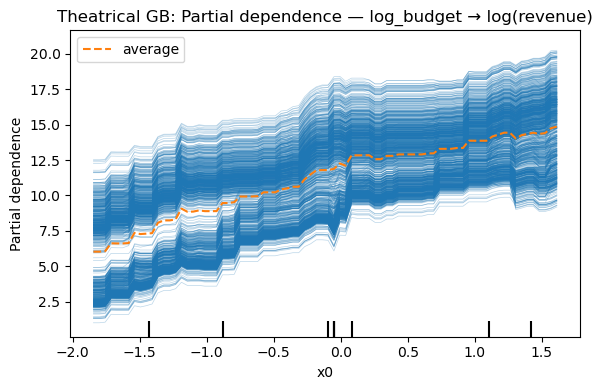

Saved → figs/theatrical_gb_pdp_log_budget.png


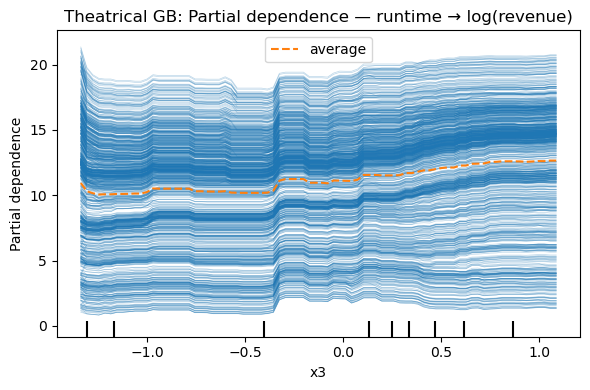

Saved → figs/theatrical_gb_pdp_runtime.png


In [17]:
# GB-T3 (robust) — PDP for the theatrical GB model using transformed matrix + indices
# Run this after GB-T1 so `g_gb`, `Xtr`, `num_feats`, `cat_feats` exist.

import os, matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

os.makedirs("figs", exist_ok=True)

# Pull pieces
best_pipe = g_gb.best_estimator_
pre  = best_pipe.named_steps["pre"]
gbr  = best_pipe.named_steps["model"]

# Transform training features and recover names in the transformed matrix
Xt = pre.transform(Xtr)

feat_names = []
feat_names += list(num_feats)  # numeric stay as-is (order preserved)
if len(cat_feats):
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    feat_names += ohe.get_feature_names_out(cat_feats).tolist()

def pdp_by_index(feat_name, out_path, title):
    if feat_name not in feat_names:
        print(f"Skip '{feat_name}': not found among transformed features.")
        return
    feat_idx = feat_names.index(feat_name)

    fig, ax = plt.subplots(figsize=(6,4))
    try:
        PartialDependenceDisplay.from_estimator(
            gbr, Xt, [feat_idx], kind="both", grid_resolution=80, ax=ax
        )
    except TypeError:
        PartialDependenceDisplay.from_estimator(
            gbr, Xt, [feat_idx], grid_resolution=80, ax=ax
        )
    # make the average line a bit thicker if present
    for ln in ax.lines:
        if getattr(ln, "get_label", lambda: "")() == "average":
            ln.set_linewidth(2.5)
    ax.set_title(title)
    ax.set_xlabel(feat_name)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    print("Saved →", out_path)

# Draw both PDPs
pdp_by_index(
    "log_budget",
    "figs/theatrical_gb_pdp_log_budget.png",
    "Theatrical GB: Partial dependence — log_budget → log(revenue)"
)
pdp_by_index(
    "runtime",
    "figs/theatrical_gb_pdp_runtime.png",
    "Theatrical GB: Partial dependence — runtime → log(revenue)"
)


In [19]:
# GB-S1 — Streaming GradientBoostingClassifier (mirrors your logistic split)

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# If rt_thresh isn’t in memory, rebuild it (75th percentile on TRAIN ONLY)
if "rt_thresh" not in globals():
    rt_thresh = str_train["rt_score"].quantile(0.75)

str_train = str_train.assign(rt_top=(str_train["rt_score"] >= rt_thresh).astype(int))
str_test  = str_test.assign(rt_top =(str_test["rt_score"]  >= rt_thresh).astype(int))

num_feats_s = [c for c in ["log_votes","runtime","netflix","hulu","prime_video","disney_plus"] if c in str_train.columns]
cat_feats_s = [c for c in ["main_genre","release_season"] if c in str_train.columns]

Xtr_s, ytr_s = str_train[num_feats_s + cat_feats_s], str_train["rt_top"]
Xte_s, yte_s = str_test[num_feats_s + cat_feats_s],  str_test["rt_top"]

# preprocess
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler",  StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot",  ohe)])
pre_s = ColumnTransformer([("num", num_pipe, num_feats_s),
                           ("cat", cat_pipe, cat_feats_s)])

gbc = GradientBoostingClassifier(random_state=0)
pipe_sgb = Pipeline([("pre", pre_s), ("model", gbc)])

param_grid_s = {
    "model__n_estimators":[200, 400],
    "model__max_depth":[2, 3],
    "model__learning_rate":[0.05, 0.10],
    "model__subsample":[0.7, 0.9],
}
g_sgb = GridSearchCV(pipe_sgb, param_grid_s, cv=5, n_jobs=-1, verbose=0)
g_sgb.fit(Xtr_s, ytr_s)

proba = g_sgb.predict_proba(Xte_s)[:,1]
pred  = (proba >= 0.5).astype(int)

print("GB Classifier (test)",
      f"AUC={roc_auc_score(yte_s, proba):.3f}",
      f"F1={f1_score(yte_s, pred):.3f}",
      f"P={precision_score(yte_s, pred):.3f}",
      f"R={recall_score(yte_s, pred):.3f}",
      f"Acc={accuracy_score(yte_s, pred):.3f}")
print("Best params:", g_sgb.best_params_)
print("Confusion matrix [[TN FP],[FN TP]]:\n", confusion_matrix(yte_s, pred))


GB Classifier (test) AUC=0.841 F1=0.598 P=0.754 R=0.495 Acc=0.794
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200, 'model__subsample': 0.7}
Confusion matrix [[TN FP],[FN TP]]:
 [[205  16]
 [ 50  49]]


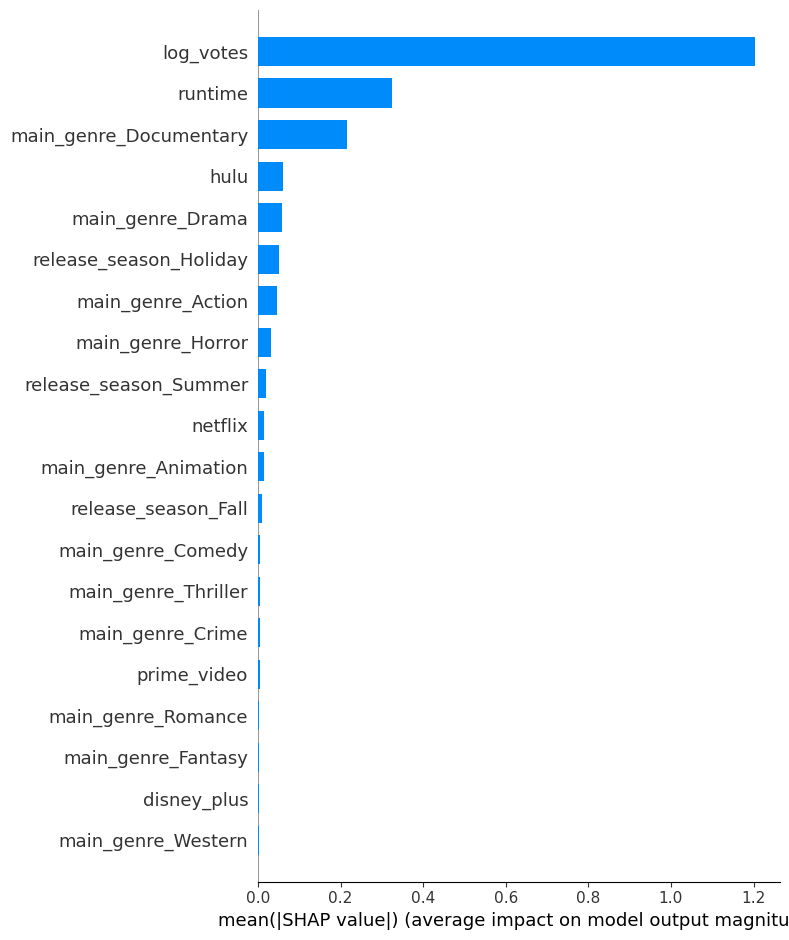

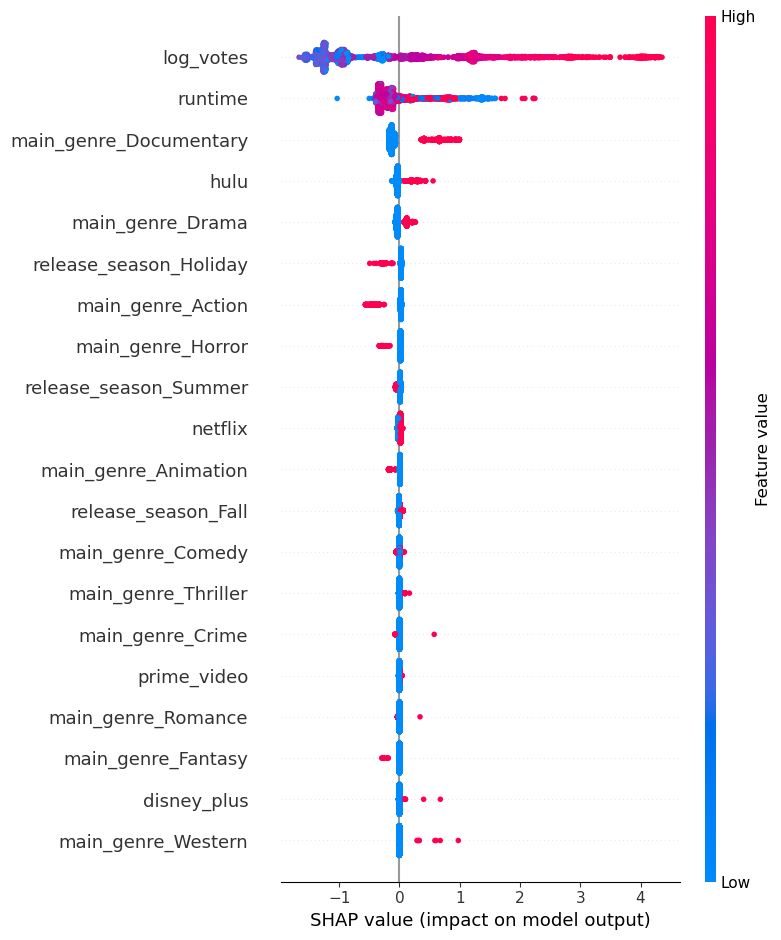

Saved → figs/streaming_gb_shap_bar.png, figs/streaming_gb_shap_beeswarm.png, tables/streaming_gb_shap_top20.csv


In [21]:
# GB-S2 — SHAP for the best streaming GB model (saves figs + a small table)

import os, sys, subprocess, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs("figs", exist_ok=True); os.makedirs("tables", exist_ok=True)

# Ensure SHAP is available
try:
    import shap
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "-q"])
    import shap

# Fitted pipeline from GB-S1
best_s = g_sgb.best_estimator_
pre_fit = best_s.named_steps["pre"]
gbc_fit = best_s.named_steps["model"]

# Transform training matrix + feature names
Xs = pre_fit.transform(Xtr_s)
feat_names = list(num_feats_s)
if len(cat_feats_s):
    ohe = pre_fit.named_transformers_["cat"].named_steps["onehot"]
    feat_names += ohe.get_feature_names_out(cat_feats_s).tolist()

# SHAP values
explainer_s = shap.TreeExplainer(gbc_fit)
shap_vals = explainer_s.shap_values(Xs)
# Robust to older SHAP returning a list for binary classification
sv = shap_vals[1] if isinstance(shap_vals, list) else shap_vals

# --- SHAP bar (global importance): DISPLAY + SAVE ---
plt.figure(figsize=(6,5))
shap.summary_plot(sv, Xs, feature_names=feat_names, plot_type="bar",
                  show=False, max_display=20)
plt.tight_layout()
plt.savefig("figs/streaming_gb_shap_bar.png", dpi=300)
plt.show()

# --- SHAP beeswarm (direction + spread): DISPLAY + SAVE ---
plt.figure(figsize=(7,9))
shap.summary_plot(sv, Xs, feature_names=feat_names, show=False, max_display=20)
plt.tight_layout()
plt.savefig("figs/streaming_gb_shap_beeswarm.png", dpi=300)
plt.show()

# --- Top-20 importance table ---
pd.DataFrame({
    "feature": feat_names,
    "mean_abs_shap": np.abs(sv).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False).head(20)\
 .to_csv("tables/streaming_gb_shap_top20.csv", index=False)

print("Saved →",
      "figs/streaming_gb_shap_bar.png,",
      "figs/streaming_gb_shap_beeswarm.png,",
      "tables/streaming_gb_shap_top20.csv")

In [25]:
# RB-T1 — Theatrical robustness: change the train/test boundary and compare
# Rebuild a minimal theatrical set from your merged dataframe if needed.

import numpy as np
import pandas as pd

# 1) Load (change the path if your CSV is elsewhere)
movies = pd.read_csv("movies_merged.csv")

# 2) Parse dates / make year
if "year" not in movies.columns:
    if "release_date" in movies.columns:
        movies["release_date"] = pd.to_datetime(movies["release_date"], errors="coerce")
        movies["year"] = movies["release_date"].dt.year
    elif "release_year" in movies.columns:
        movies["year"] = pd.to_numeric(movies["release_year"], errors="coerce")

# 3) Safe log helpers
def make_log(col, new, one_plus=False):
    if col in movies.columns and new not in movies.columns:
        vals = pd.to_numeric(movies[col], errors="coerce")
        if one_plus:
            movies[new] = np.log1p(vals)               # allows zeros
        else:
            movies[new] = np.where(vals > 0, np.log(vals), np.nan)

make_log("budget", "log_budget")
make_log("revenue", "log_revenue")
make_log("vote_count", "log_votes", one_plus=True)

# popularity sometimes has zeros; prefer log1p
if "log_popularity" not in movies.columns and "popularity" in movies.columns:
    pv = pd.to_numeric(movies["popularity"], errors="coerce")
    movies["log_popularity"] = np.log1p(pv)

# 4) Runtime numeric
if "runtime" in movies.columns:
    movies["runtime"] = pd.to_numeric(movies["runtime"], errors="coerce")

# 5) Main genre (fallback from 'genres' if needed)
if "main_genre" not in movies.columns and "genres" in movies.columns:
    movies["main_genre"] = (
        movies["genres"].fillna("").str.split(",").str[0].str.strip().replace("", np.nan)
    )

# 6) Release season (from release_date or month_name)
if "release_season" not in movies.columns:
    if "release_date" in movies.columns:
        m = movies["release_date"].dt.month
    elif "month_name" in movies.columns:
        month_map = {
            "January":1,"February":2,"March":3,"April":4,"May":5,"June":6,
            "July":7,"August":8,"September":9,"October":10,"November":11,"December":12
        }
        m = movies["month_name"].map(month_map)
    else:
        m = pd.Series([np.nan]*len(movies))

    def season(mm):
        if pd.isna(mm): return np.nan
        if mm in [12,1,2]:  return "Winter"
        if mm in [3,4,5]:   return "Spring"
        if mm in [6,7,8]:   return "Summer"
        if mm in [9,10,11]: return "Fall"

    movies["release_season"] = m.map(season)

# 7) Channel (fallback inference if not present)
if "channel" not in movies.columns:
    nf = pd.to_numeric(movies.get("netflix", 0), errors="coerce").fillna(0)
    hu = pd.to_numeric(movies.get("hulu", 0), errors="coerce").fillna(0)
    pv = pd.to_numeric(movies.get("prime_video", 0), errors="coerce").fillna(0)
    dp = pd.to_numeric(movies.get("disney_plus", 0), errors="coerce").fillna(0)
    rev = pd.to_numeric(movies.get("revenue", 0), errors="coerce").fillna(0)
    movies["channel"] = np.where(
        rev > 0, "theatrical",
        np.where(nf + hu + pv + dp > 0, "streaming", "unknown")
    )

# 8) Quick sanity check
needed = ["log_revenue","log_budget","log_votes","log_popularity",
          "runtime","main_genre","release_season","year","channel"]
missing = [c for c in needed if c not in movies.columns]
print("Missing after rebuild:", missing)
display(movies.head(3))


Missing after rebuild: []


,id,title,title_norm,release_date,year,month_name,quarter,runtime,genres,budget,...,popularity,log_popularity,main_genre,release_season,netflix,hulu,prime_video,disney_plus,rt_score,channel
0,299536,Avengers: Infinity War,avengers: infinity war,2018-04-25,2018,April,2,149,"Adventure, Action, Science Fiction",300000000.0,...,154.340,5.045616,Adventure,Spring,0,0,0,1,90.0,theatrical
1,299534,Avengers: Endgame,avengers: endgame,2019-04-24,2019,April,2,181,"Adventure, Science Fiction, Action",356000000.0,...,91.756,4.529972,Adventure,Spring,0,0,0,1,90.0,theatrical
2,475557,Joker,joker,2019-10-01,2019,October,4,122,"Crime, Thriller, Drama",55000000.0,...,54.522,4.016779,Crime,Fall,0,0,0,0,NaN,theatrical


In [27]:
# RB-T1 — Theatrical robustness: move the cutoff 2021 → 2022 and compare

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import os

os.makedirs("tables", exist_ok=True)

theatrical = (movies[movies["channel"].eq("theatrical")]
              .dropna(subset=["log_revenue"])).copy()

num_feats = [c for c in ["log_budget","log_votes","runtime","log_popularity"] if c in theatrical.columns]
cat_feats = [c for c in ["main_genre","release_season"] if c in theatrical.columns]
feat_list = num_feats + cat_feats

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("sc",  StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("oh",  ohe)])
pre = ColumnTransformer([("num", num_pipe, num_feats),
                         ("cat", cat_pipe, cat_feats)])

def eval_cutoff(cutoff):
    tr = theatrical[theatrical["year"] <= cutoff]
    te = theatrical[theatrical["year"] >  cutoff]
    Xtr, ytr = tr[feat_list], tr["log_revenue"]
    Xte, yte = te[feat_list], te["log_revenue"]

    pipe = Pipeline([("pre", pre),
                     ("model", GradientBoostingRegressor(random_state=0))])

    grid = {
        "model__n_estimators":[300, 500],
        "model__max_depth":[2, 3],
        "model__learning_rate":[0.05, 0.10],
        "model__subsample":[0.7, 0.9],
    }
    gs = GridSearchCV(pipe, grid, cv=5, n_jobs=-1, verbose=0)
    gs.fit(Xtr, ytr)

    pred = gs.predict(Xte)
    return {"cutoff":cutoff, "train_n":len(tr), "test_n":len(te),
            "r2":r2_score(yte,pred), "mae":mean_absolute_error(yte,pred),
            "best_params":gs.best_params_}

res = pd.DataFrame([eval_cutoff(2021), eval_cutoff(2022)])
res.to_csv("tables/robust_theatrical_splits.csv", index=False)
print(res)
print("Saved → tables/robust_theatrical_splits.csv")


   cutoff  train_n  test_n        r2       mae  \
0    2021     2650    1993  0.735848  2.042897   
1    2022     3357    1286  0.656321  2.147113   

                                         best_params  
0  {'model__learning_rate': 0.1, 'model__max_dept...  
1  {'model__learning_rate': 0.05, 'model__max_dep...  
Saved → tables/robust_theatrical_splits.csv


In [29]:
# RB-T2 — CPI-adjust budgets/revenues and re-run GB (same split as your main run)

import numpy as np
import pandas as pd

# Annual CPI-U index (1982-84=100). You can tweak if you have a different table.
CPI = {2018:251.1, 2019:255.7, 2020:258.8, 2021:270.9, 2022:292.7, 2023:305.4, 2024:312.0}
base = CPI[max(y for y in CPI)]  # latest ≈ 2024

t = theatrical.copy()
t = t[t["year"].isin(CPI.keys())].copy()
t["cpi_factor"] = t["year"].map(lambda y: base / CPI[y])

# Deflate to base-year dollars, rebuild logs
for col in ["budget","revenue"]:
    if col in t.columns:
        vals = pd.to_numeric(t[col], errors="coerce")
        t[f"{col}_cpi"] = vals * t["cpi_factor"]
        t[f"log_{col}_cpi"] = np.where(t[f"{col}_cpi"]>0, np.log(t[f"{col}_cpi"]), np.nan)

# Use CPI target & features
t2 = t.dropna(subset=["log_revenue_cpi"]).copy()
num_feats_cpi = [f for f in ["log_budget_cpi","log_votes","runtime","log_popularity"] if f in t2.columns]
cat_feats_cpi = cat_feats
feat_list_cpi = num_feats_cpi + cat_feats_cpi

# train through 2022 (match main)
train = t2[t2["year"] <= 2022]
test  = t2[t2["year"] >  2022]

Xtr_nom, ytr_nom = train[feat_list].copy(), train["log_revenue"]
Xte_nom, yte_nom = test[feat_list].copy(),  test["log_revenue"]

Xtr_cpi, ytr_cpi = train[feat_list_cpi].copy(), train["log_revenue_cpi"]
Xte_cpi, yte_cpi = test[feat_list_cpi].copy(),  test["log_revenue_cpi"]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

try:
    ohe2 = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe2 = OneHotEncoder(handle_unknown="ignore", sparse=False)

def make_pipe(num, cat):
    nump = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
    catp = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", ohe2)])
    pre2 = ColumnTransformer([("num", nump, num), ("cat", catp, cat)])
    return Pipeline([("pre", pre2),
                     ("model", GradientBoostingRegressor(n_estimators=500, max_depth=3,
                                                        learning_rate=0.1, subsample=0.9,
                                                        random_state=0))])

pipe_nom = make_pipe(num_feats, cat_feats)
pipe_cpi = make_pipe(num_feats_cpi, cat_feats_cpi)

pipe_nom.fit(Xtr_nom, ytr_nom)
pipe_cpi.fit(Xtr_cpi, ytr_cpi)

pred_nom = pipe_nom.predict(Xte_nom)
pred_cpi = pipe_cpi.predict(Xte_cpi)

out = pd.DataFrame({
    "version":["nominal","cpi_adjusted"],
    "r2":[r2_score(yte_nom,pred_nom), r2_score(yte_cpi,pred_cpi)],
    "mae":[mean_absolute_error(yte_nom,pred_nom), mean_absolute_error(yte_cpi,pred_cpi)],
    "test_n":[len(test), len(test)]
})
out.to_csv("tables/robust_cpi_vs_nominal.csv", index=False)
print(out)
print("Saved → tables/robust_cpi_vs_nominal.csv")


        version        r2       mae  test_n
0       nominal  0.641049  2.178692    1286
1  cpi_adjusted  0.637059  2.278290    1286
Saved → tables/robust_cpi_vs_nominal.csv


In [31]:
# S1 — STREAMING DATA PREP (run this first)

import os
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

os.makedirs("figs", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# 1) take streaming titles with a valid RT score
stream = movies[(movies["channel"] == "streaming") & movies["rt_score"].notna()].copy()

# 2) time split: train ≤ 2020, test = 2021 (keeps proposal’s leakage control)
train_s = stream[stream["year"] <= 2020].copy()
test_s  = stream[stream["year"] == 2021].copy()

# 3) label = top-quartile RT on *train only*
rt_thr = train_s["rt_score"].quantile(0.75)
train_s["y"] = (train_s["rt_score"] >= rt_thr).astype(int)
test_s["y"]  = (test_s["rt_score"]  >= rt_thr).astype(int)   # same threshold, no leakage

# 4) features (numeric + categorical)
num_feats = [c for c in ["log_votes","runtime","netflix","hulu","prime_video","disney_plus"] if c in stream.columns]
cat_feats = [c for c in ["main_genre","release_season"] if c in stream.columns]
feat_list = num_feats + cat_feats

# 5) preprocessor skeleton (we’ll plug into a classifier next)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("sc",  StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("oh",  ohe)])
pre = ColumnTransformer([("num", num_pipe, num_feats),
                         ("cat", cat_pipe, cat_feats)])

Xtr, ytr = train_s[feat_list], train_s["y"]
Xte, yte = test_s[feat_list],  test_s["y"]

print(f"Train n={len(Xtr)}  Test n={len(Xte)}  |  RT threshold (train Q3)={rt_thr:.1f}")
print("Numeric:", num_feats)
print("Categorical:", cat_feats)


Train n=2586  Test n=320  |  RT threshold (train Q3)=59.0
Numeric: ['log_votes', 'runtime', 'netflix', 'hulu', 'prime_video', 'disney_plus']
Categorical: ['main_genre', 'release_season']


Best params: {'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__n_estimators': 200, 'gb__subsample': 0.8}
CV best ROC AUC: 0.844

STREAMING — Gradient Boosting (test=2021)
AUC: 0.839
F1: 0.588
Precision: 0.704
Recall: 0.505
Accuracy: 0.781
Positive rate (test): 0.309


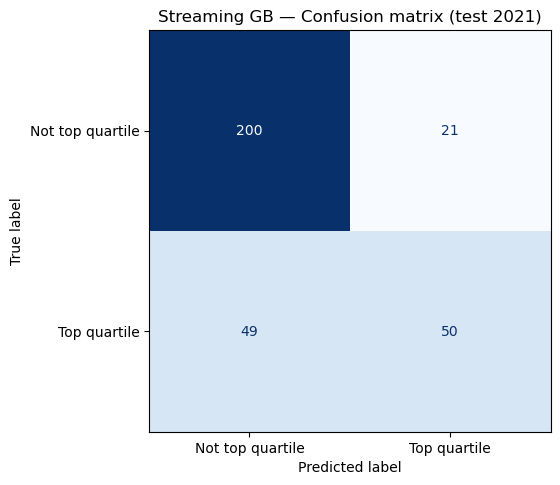

Saved → tables/stream_gb_metrics.csv and figs/stream_gb_confusion.png


In [33]:
# S2 — STREAMING: Gradient Boosting + time-aware CV + test evaluation

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- keep time order inside the train set (2018→2020) for CV ---
order_idx = train_s.sort_values("year").index
Xtr_ord = Xtr.loc[order_idx]
ytr_ord = ytr.loc[order_idx]

# pipeline: preprocessor from S1 + GB
gb = GradientBoostingClassifier(random_state=0)
pipe_gb = Pipeline([("pre", pre), ("gb", gb)])

# small, sensible grid (keeps runtime reasonable)
param_grid = {
    "gb__n_estimators": [200, 400],
    "gb__learning_rate": [0.05, 0.1],
    "gb__max_depth": [2, 3],
    "gb__subsample": [0.8, 1.0],
}

# time-aware CV: split the ordered train set into forward time folds
tscv = TimeSeriesSplit(n_splits=3)

gs = GridSearchCV(
    pipe_gb,
    param_grid=param_grid,
    cv=tscv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    verbose=0,
)

gs.fit(Xtr_ord, ytr_ord)

print("Best params:", gs.best_params_)
print(f"CV best ROC AUC: {gs.best_score_:.3f}")

# --- test on 2021 ---
best_model = gs.best_estimator_
proba = best_model.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.5).astype(int)  # we can tune this threshold later if needed

metrics = {
    "AUC": roc_auc_score(yte, proba),
    "F1": f1_score(yte, pred),
    "Precision": precision_score(yte, pred),
    "Recall": recall_score(yte, pred),
    "Accuracy": accuracy_score(yte, pred),
    "Positive rate (test)": float(np.mean(yte)),
}

print("\nSTREAMING — Gradient Boosting (test=2021)")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

# confusion matrix (draw + save)
cm = confusion_matrix(yte, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not top quartile","Top quartile"])
fig, ax = plt.subplots(figsize=(5.5, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
ax.set_title("Streaming GB — Confusion matrix (test 2021)")
plt.tight_layout()
plt.savefig("figs/stream_gb_confusion.png", dpi=300)
plt.show()

# save metrics table
m_tbl = pd.DataFrame([metrics])
m_tbl.to_csv("tables/stream_gb_metrics.csv", index=False)
print("Saved → tables/stream_gb_metrics.csv and figs/stream_gb_confusion.png")


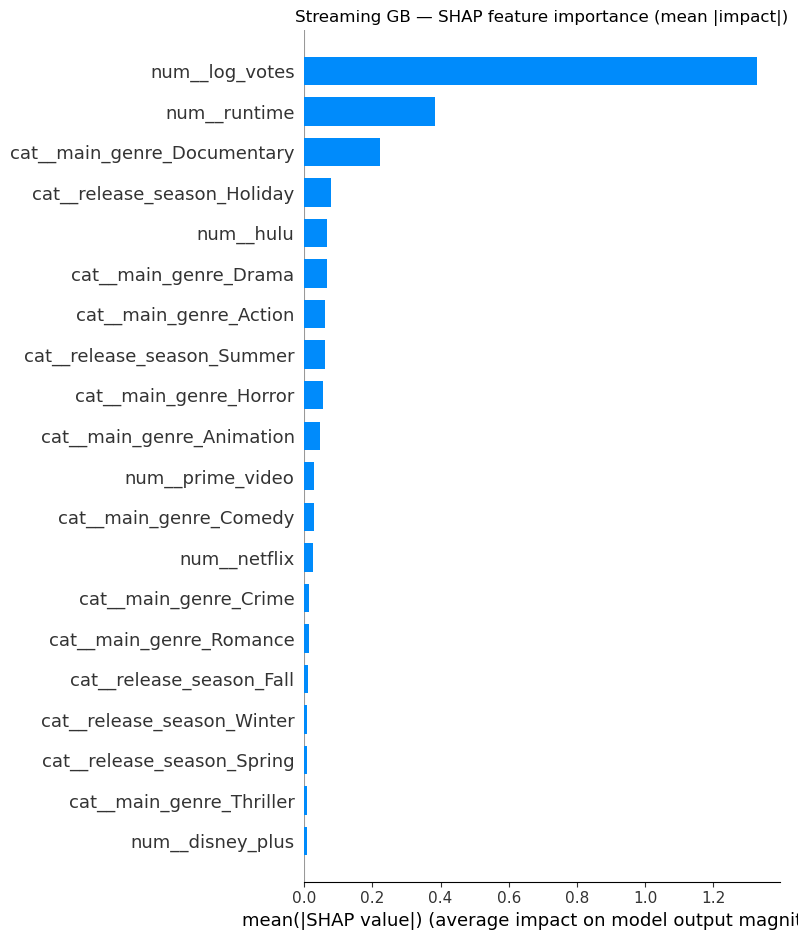

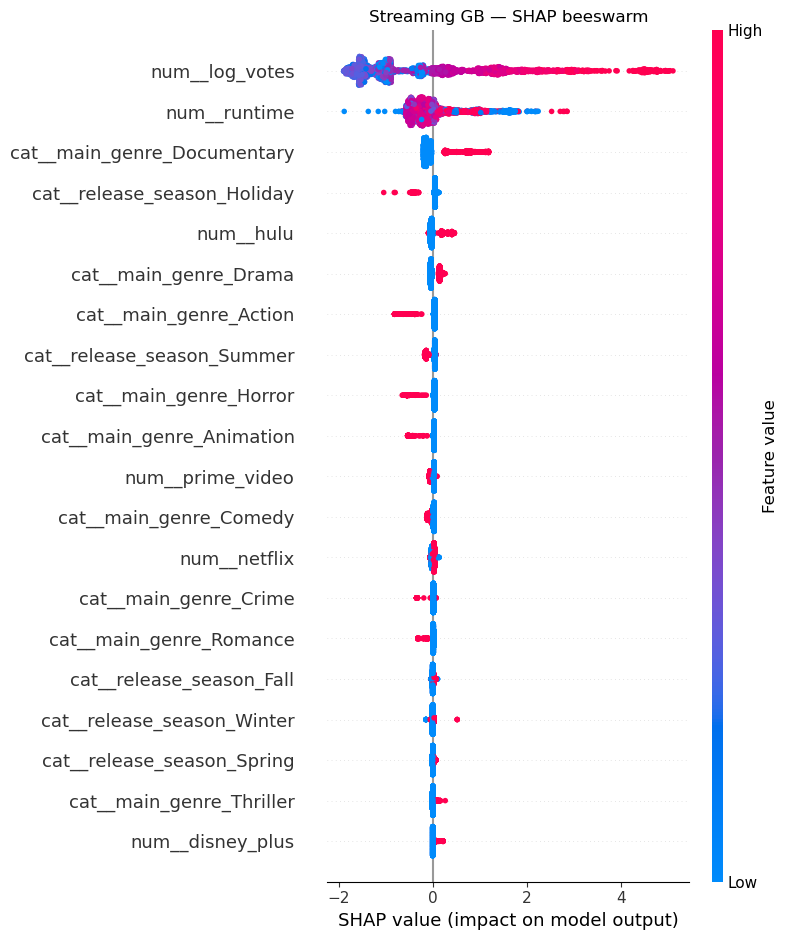

Saved → figs/stream_gb_shap_bar.png and figs/stream_gb_shap_beeswarm.png


In [35]:
# S3 — STREAMING: SHAP (bar + beeswarm) for the tuned GB model

import numpy as np
import matplotlib.pyplot as plt
import shap

# grab preprocessor + gb from the tuned pipeline
pre_s   = best_model.named_steps["pre"]
gb_s    = best_model.named_steps["gb"]

# transform features the same way the model sees them
Xtr_mat = pre_s.transform(Xtr_ord)

# try to recover feature names (falls back to f0..fk if not available)
try:
    feat_names = pre_s.get_feature_names_out()
except Exception:
    feat_names = [f"f{i}" for i in range(Xtr_mat.shape[1])]

# Tree SHAP for Gradient Boosting
explainer = shap.TreeExplainer(gb_s)
shap_vals = explainer.shap_values(Xtr_mat)   # (n_samples, n_features)

# 1) Bar plot: average absolute impact
shap.summary_plot(
    shap_vals, Xtr_mat, feature_names=feat_names,
    plot_type="bar", show=False, max_display=20
)
plt.title("Streaming GB — SHAP feature importance (mean |impact|)")
plt.tight_layout()
plt.savefig("figs/stream_gb_shap_bar.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Beeswarm: direction + magnitude
shap.summary_plot(
    shap_vals, Xtr_mat, feature_names=feat_names,
    show=False, max_display=20
)
plt.title("Streaming GB — SHAP beeswarm")
plt.tight_layout()
plt.savefig("figs/stream_gb_shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved → figs/stream_gb_shap_bar.png and figs/stream_gb_shap_beeswarm.png")


Project root: /Users/samadrita_roy/Documents/Data Analytics
Tables dir  : /Users/samadrita_roy/Documents/Data Analytics/tables
Figures dir : /Users/samadrita_roy/Documents/Data Analytics/figs_presentation_final
Using channel/cohort counts file : channel_counts.csv
Using platform counts file       : platform_counts.csv


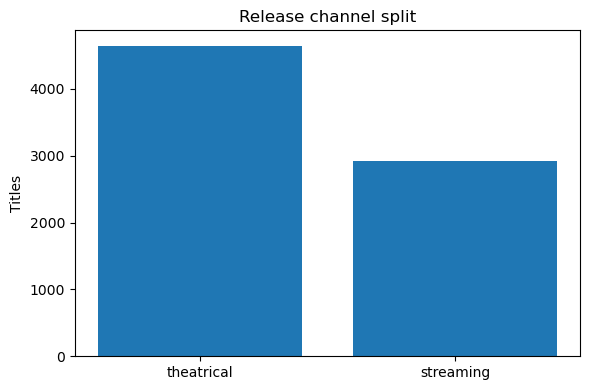

Saved: /Users/samadrita_roy/Documents/Data Analytics/figs_presentation_final/cohort_split_bars.png


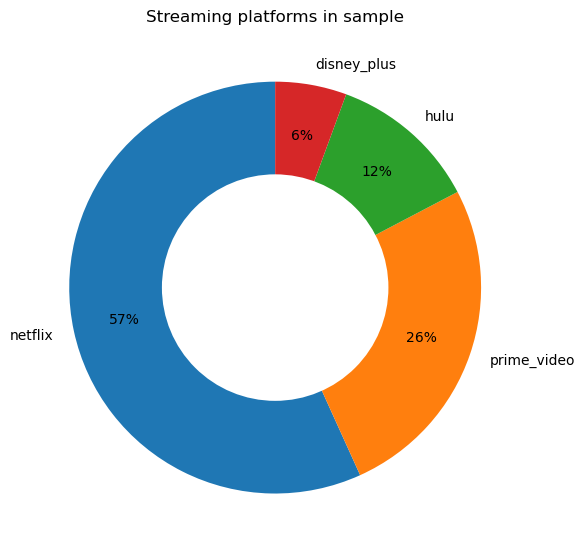

Saved: /Users/samadrita_roy/Documents/Data Analytics/figs_presentation_final/platforms_donut.png

All good. Paste those two PNGs into your slides:
 • cohort_split_bars.png  (left tile under 'Data & Cohorts')
 • platforms_donut.png    (right tile under 'Data & Cohorts')


In [13]:
# ------------------ FIGURE MAKER: DATA & COHORT SLIDE ------------------
from pathlib import Path
import sys, re
import pandas as pd
import matplotlib.pyplot as plt

# 0) Find your project root and key folders
cwd = Path.cwd()
candidates = [
    cwd,
    cwd.parent,
    cwd / "Documents" / "Data Analytics",
    cwd / "Data Analytics",
]
ROOT = None
for c in candidates:
    if (c / "tables").exists() and (c / "figs_presentation_final").exists():
        ROOT = c
        break
if ROOT is None:
    # last-resort: search upward for a folder that has both "tables" and "figs_presentation_final"
    p = cwd
    for _ in range(5):
        if (p / "tables").exists() and (p / "figs_presentation_final").exists():
            ROOT = p
            break
        p = p.parent

if ROOT is None:
    raise FileNotFoundError(
        "Couldn't find your project root. Make sure this notebook lives in the same folder that contains\n"
        "'tables/' and 'figs_presentation_final/'. If it does, re-run the cell.\n"
        f"CWD: {cwd}"
    )

TABLES = ROOT / "tables"
FIGS   = ROOT / "figs_presentation_final"
FIGS.mkdir(parents=True, exist_ok=True)

print(f"Project root: {ROOT}")
print(f"Tables dir  : {TABLES}")
print(f"Figures dir : {FIGS}")

# 1) Helper to pick a CSV by “contains” logic
def pick_csv(contains: list[str], default=None):
    contains = [s.lower() for s in contains]
    hits = []
    for f in TABLES.glob("*.csv"):
        name = f.name.lower()
        if all(s in name for s in contains):
            hits.append(f)
    if hits:
        # prefer the shortest name (usually the intended table)
        return sorted(hits, key=lambda p: len(p.name))[0]
    return default

# 2) Load channel/platform counts with column name auto-detect
def load_counts(path: Path, label_candidates=("channel","platform","cohort"), count_candidates=("count","n","freq","total")):
    df = pd.read_csv(path)
    # find label column
    label_col = None
    for cand in label_candidates:
        for col in df.columns:
            if re.sub(r"[^a-z]","",col.lower()) == cand:
                label_col = col; break
        if label_col: break
    # find count column
    count_col = None
    for cand in count_candidates:
        for col in df.columns:
            if re.sub(r"[^a-z]","",col.lower()) == cand:
                count_col = col; break
        if count_col: break
    if label_col is None or count_col is None:
        raise ValueError(
            f"Could not detect label/count columns in {path.name}. "
            f"Columns found: {list(df.columns)}"
        )
    df = df[[label_col, count_col]].copy()
    df.columns = ["label","count"]
    return df

# 3) Find files
channel_csv  = pick_csv(["channel","count"]) or pick_csv(["cohort","count"])
platform_csv = pick_csv(["platform","count"])

if channel_csv is None:
    raise FileNotFoundError(
        "I couldn't find your **channel/cohort** counts CSV in tables/. "
        "Name it something like 'channel_counts.csv' (it can include 'channel' or 'cohort' and 'count' in the filename)."
    )
if platform_csv is None:
    raise FileNotFoundError(
        "I couldn't find your **platform** counts CSV in tables/. "
        "Name it something like 'platform_counts.csv' (it should include 'platform' and 'count' in the filename)."
    )

print(f"Using channel/cohort counts file : {channel_csv.name}")
print(f"Using platform counts file       : {platform_csv.name}")

channel_counts  = load_counts(channel_csv,  label_candidates=("channel","cohort"),
                              count_candidates=("count","n","freq","total"))
platform_counts = load_counts(
    platform_csv,
    label_candidates=("platform",),
    count_candidates=("titles", "count", "n", "freq", "total")
)

# 4) Plot — Cohort split (bars)
plt.figure(figsize=(6,4))
plt.bar(channel_counts["label"], channel_counts["count"])
plt.title("Release channel split")
plt.ylabel("Titles")
plt.tight_layout()
cohort_bar_path = FIGS / "cohort_split_bars.png"
plt.savefig(cohort_bar_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {cohort_bar_path.resolve()}")

# 5) Plot — Platforms donut
fig, ax = plt.subplots(figsize=(6,6))
wedges, txts, autotxts = ax.pie(
    platform_counts["count"],
    labels=platform_counts["label"],
    autopct="%1.0f%%",
    startangle=90,
    pctdistance=0.75,
)
# donut hole
centre = plt.Circle((0,0), 0.55, fc="white")
fig.gca().add_artist(centre)
ax.set_title("Streaming platforms in sample")
plt.tight_layout()
platform_donut_path = FIGS / "platforms_donut.png"
plt.savefig(platform_donut_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {platform_donut_path.resolve()}")

print("\nAll good. Paste those two PNGs into your slides:")
print(" • cohort_split_bars.png  (left tile under 'Data & Cohorts')")
print(" • platforms_donut.png    (right tile under 'Data & Cohorts')")
# --------------------------------------

In [25]:
# Create two slide-ready figures for the Theatrical Model (Elastic Net):
# 1) A compact "metrics badge" PNG
# 2) A robustness chart comparing R² across test splits and CPI vs nominal

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

base = Path("/Document/Data Analytics/figs")
cpi_df = pd.read_csv(base/"robust_cpi_vs_nominal.csv")
splits_df = pd.read_csv(base/"robust_theatrical_splits.csv")
model_df = pd.read_csv(base/"theatrical_model_results.csv")

# --- 1) Metrics badge ---
badge_text_top = "Theatrical Model — Elastic Net"
r2 = model_df['R2'].iloc[0]
mae = model_df['MAE_log'].iloc[0]
period = model_df['test_period'].iloc[0]

fig1, ax1 = plt.subplots(figsize=(9, 2.2))
ax1.axis('off')
ax1.text(0.02, 0.80, badge_text_top, fontsize=20, weight='bold', va='top')
ax1.text(0.02, 0.30, f"R² {r2:.3f}   |   MAE (log) {mae:.2f}   |   Test: {period}",
         fontsize=16, va='center')
badge_path = str(base/"elasticnet_metrics_badge.png")
plt.savefig(badge_path, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.close(fig1)

# --- 2) Robustness chart ---
fig2, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Left: Split robustness
axes[0].bar([str(int(x)) for x in splits_df['cutoff']], splits_df['r2'])
axes[0].set_title("R² by Train/Test Cutoff")
axes[0].set_ylabel("R² (test)")
for i, (x, r2v, tn) in enumerate(zip(splits_df['cutoff'], splits_df['r2'], splits_df['test_n'])):
    axes[0].text(i, r2v + 0.01, f"{r2v:.3f}\nn={int(tn)}", ha='center', va='bottom', fontsize=10)

# Right: CPI vs nominal
axes[1].bar(cpi_df['version'], cpi_df['r2'])
axes[1].set_title("R² — Nominal vs CPI-adjusted")
for i, (ver, r2v, maev) in enumerate(zip(cpi_df['version'], cpi_df['r2'], cpi_df['mae'])):
    axes[1].text(i, r2v + 0.01, f"{r2v:.3f}\nMAE {maev:.2f}", ha='center', va='bottom', fontsize=10)

robust_path = str(base/"elasticnet_robustness.png")
plt.savefig(robust_path, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.close(fig2)

badge_path, robust_path


FileNotFoundError: [Errno 2] No such file or directory: '/Document/Data Analytics/figs/robust_cpi_vs_nominal.csv'